<h1> Convolutional network </h1>

I think that a convolutional network could help as a 9x9 grid is already big enough to count as a picutre.

In [1]:
# own skrips
import helperfile as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
import keras.backend as k

In [20]:
from uncertainties import unumpy as unp

In [2]:
def loss_flip_weighted(y_true, y_pred):
    bs = int(tf.size(y_true)/6) # batchsize
    ort_AL = 0.5 # cm
    E_AL = 2.5 # GeV
    weights = [tf.ones(bs)*ort_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*E_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*E_AL]
    sq = k.square((y_true - y_pred) / tf.transpose(weights))
    mse = k.sum(sq, axis=1)
    
    y_pred_flipped = tf.roll(y_pred, 3, axis=1)
    sq_flipped = k.square((y_true - y_pred_flipped) / tf.transpose(weights))
    mse_flipped = k.sum(sq_flipped, axis=1)
    vec = tf.stack([mse, mse_flipped], axis=1)
    loss = k.min(vec, axis=1)
    return loss
    
def flip_output_weights(output):
    '''output is output of NN'''
    ort_AL = 0.5 # cm
    E_AL = 2.5 # GeV
    weights = np.ones((len(output), 6)) * np.array([ort_AL, ort_AL, E_AL, ort_AL, ort_AL, E_AL])
    #out_w = out/weights
    output_flipped = np.roll(output, 3, axis=1)
    mse = np.sum(np.square(output/weights-ipd.veri_truth/weights), axis=1)
    mse_flipped = np.sum(np.square(output_flipped/weights-ipd.veri_truth/weights), axis=1)
    ind_flip = np.where(mse_flipped<mse)
    output[ind_flip] = np.roll(output[ind_flip], 3, axis=1)
    return output

In [4]:
rootfile = uproot.open('./stage4_clusters_minDist2cm.root')
ipd = hf.InputData_2photon(rootfile, min_dist=4, sort_cond='none')
ipd.form_cluster()
ipd.train_test_split()

Initialized object
Cutted  938261  clusters due to photon pair with distance smaller than  4  cm.
Start shaping clusters in a  (9, 9)  grid...
Shaping the clusters took  239.49023175239563 s
Splitted data into training and test set!
Prepared 'veri_truth' data
Prepared 'veri_fit' data (Lednev fit from coral)


In [5]:
model = tf.keras.models.Sequential() # 166,274 parameter

# alias to make it shorter to access the layers
layers = tf.keras.layers

# filters - 6 kernel als output
# padding: same - eine Reihe mit null
model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(9,9, 1), padding="same"))
#model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
#model.add(layers.Conv2D(filters=6, kernel_size=(2, 2), activation='relu', input_shape=(4,4, 6), padding="same"))
#model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
# output von 6 von Average Pooling -> input in conv2d
# output von conv2d ist 16
# -> 6x16 kernels!
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation = 'relu'))
model.add(layers.Dense(units=128, activation = 'relu'))
model.add(layers.Dense(units=64, activation = 'relu'))
model.add(layers.Dense(units=6, activation = 'relu'))

model.summary()
model.compile(loss=loss_flip_weighted, optimizer=Adam(learning_rate=0.0001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 6)           60        
_________________________________________________________________
flatten (Flatten)            (None, 486)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               124672    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 166,274
Trainable params: 166,274
Non-trainable params: 0
__________________________________________________

In [6]:
print("Start training the network with ", len(ipd.clusters_t), " clusters...")
a = time.time()
clus = ipd.clusters_t.reshape(len(ipd.training),9,9, 1)
fit_hist = model.fit(clus, ipd.training, batch_size=64, epochs=100, validation_split=0.1)
b = time.time()
print('This took ', (b-a)/60, ' min')

Start training the network with  842056  clusters...
Epoch 1/100
11842/11842 [==============================] - 17s 1ms/step - loss: 394.6729 - val_loss: 170.6541
Epoch 2/100
11842/11842 [==============================] - 17s 1ms/step - loss: 134.1584 - val_loss: 113.7690
Epoch 3/100
11842/11842 [==============================] - 17s 1ms/step - loss: 100.6941 - val_loss: 92.0256
Epoch 4/100
11842/11842 [==============================] - 17s 1ms/step - loss: 85.3605 - val_loss: 80.6746
Epoch 5/100
11842/11842 [==============================] - 17s 1ms/step - loss: 76.1627 - val_loss: 73.2778
Epoch 6/100
11842/11842 [==============================] - 17s 1ms/step - loss: 69.5485 - val_loss: 67.6251
Epoch 7/100
11842/11842 [==============================] - 17s 1ms/step - loss: 64.1883 - val_loss: 61.5371
Epoch 8/100
11842/11842 [==============================] - 17s 1ms/step - loss: 59.8067 - val_loss: 60.4424
Epoch 9/100
11842/11842 [==============================] - 17s 1ms/step - loss

11842/11842 [==============================] - 17s 1ms/step - loss: 17.8418 - val_loss: 19.1683
Epoch 76/100
11842/11842 [==============================] - 17s 1ms/step - loss: 18.0241 - val_loss: 19.4426
Epoch 77/100
11842/11842 [==============================] - 17s 1ms/step - loss: 17.8549 - val_loss: 20.1523
Epoch 78/100
11842/11842 [==============================] - 17s 1ms/step - loss: 17.6618 - val_loss: 19.9510
Epoch 79/100
11842/11842 [==============================] - 17s 1ms/step - loss: 17.6735 - val_loss: 19.5151
Epoch 80/100
11842/11842 [==============================] - 17s 1ms/step - loss: 17.8092 - val_loss: 20.1880
Epoch 81/100
11842/11842 [==============================] - 17s 1ms/step - loss: 17.7930 - val_loss: 19.6992
Epoch 82/100
11842/11842 [==============================] - 17s 1ms/step - loss: 17.5241 - val_loss: 19.5738
Epoch 83/100
11842/11842 [==============================] - 17s 1ms/step - loss: 17.3556 - val_loss: 19.0319
Epoch 84/100
11842/11842 [======

In [8]:
model.save('./models/model_conv2d_firsttry')

INFO:tensorflow:Assets written to: ./models/model_conv2d_firsttry/assets


In [11]:
clus_v = ipd.clusters_v.reshape(len(ipd.veri_truth),9,9, 1)
output = model.predict(clus_v)
output = flip_output_weights(output) # flip output with correct labeling

ev = hf.Evaluation_2photon(ipd, output) # create object to help with evaluation


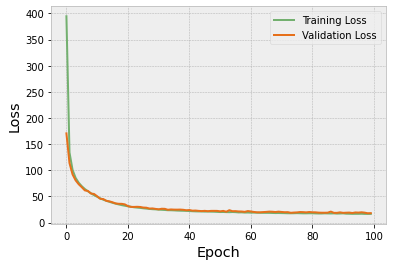

In [13]:
ev.training_vs_validation_loss(fit_hist, save=False) # save loss functions

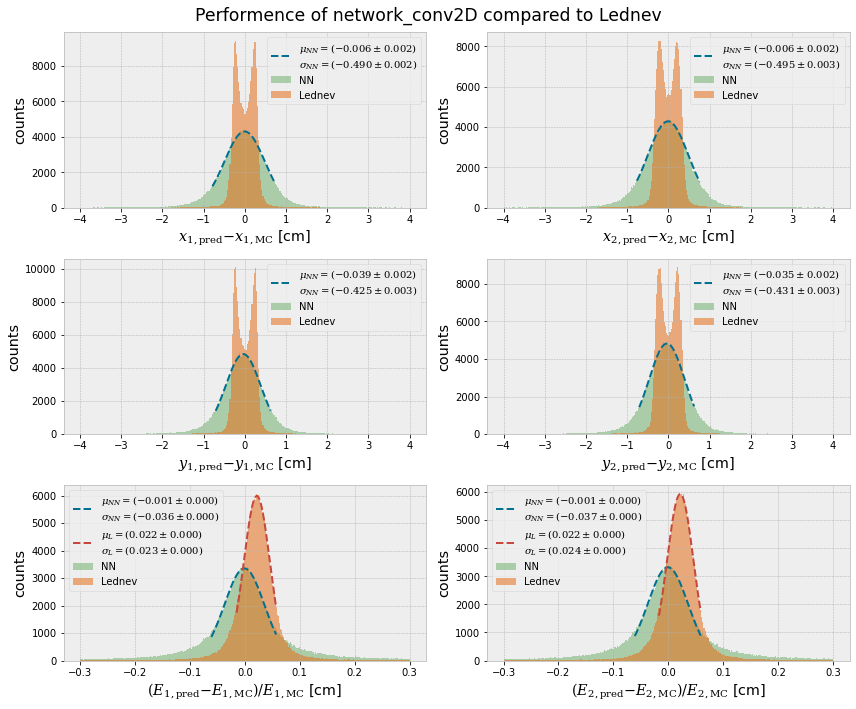

In [14]:
fit_param = ev.show_hist_NN_withLednev(figsave=(False, "network_" + 'conv2D'))

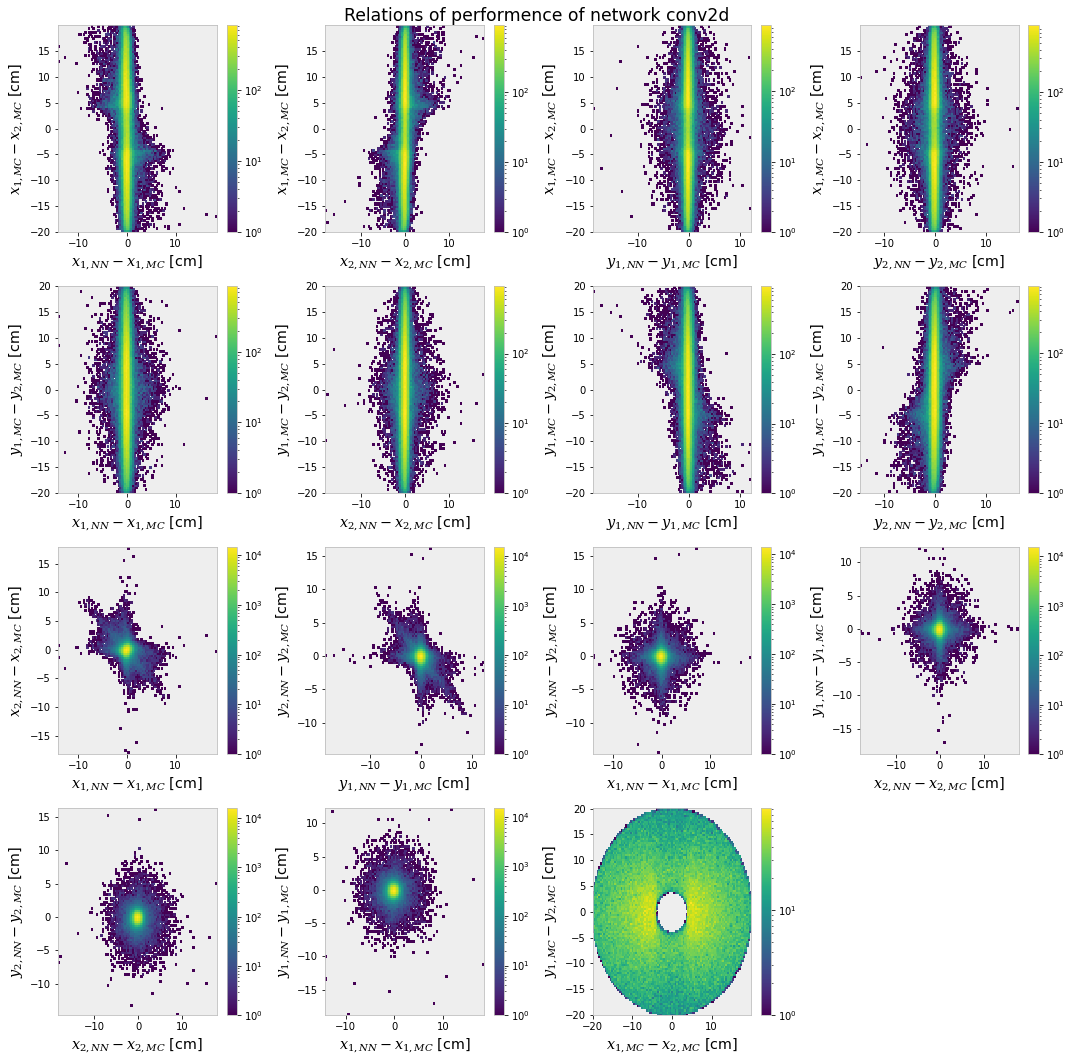

In [16]:
ev.show_2d_hist(figsave=True, title="conv2d")

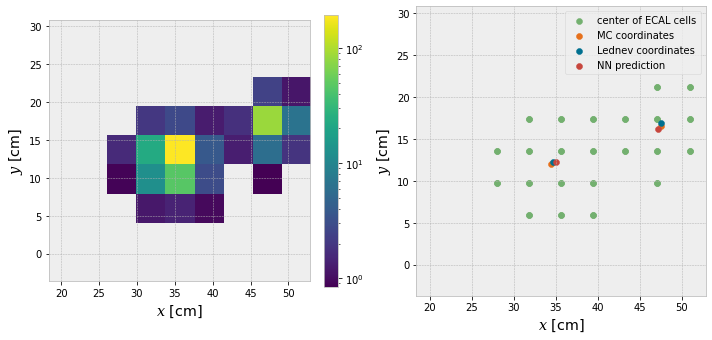

0


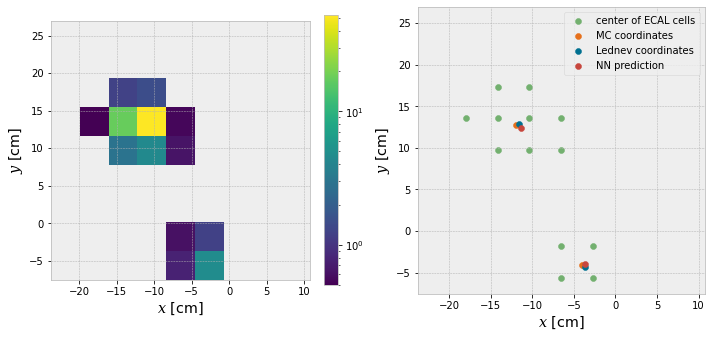

1


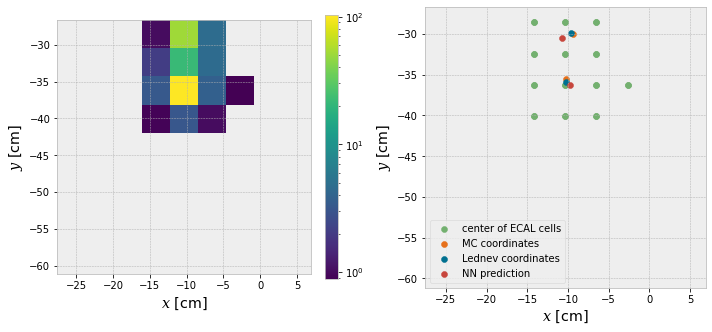

2


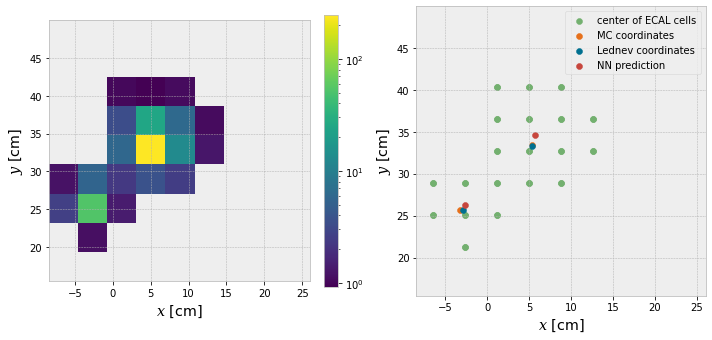

3


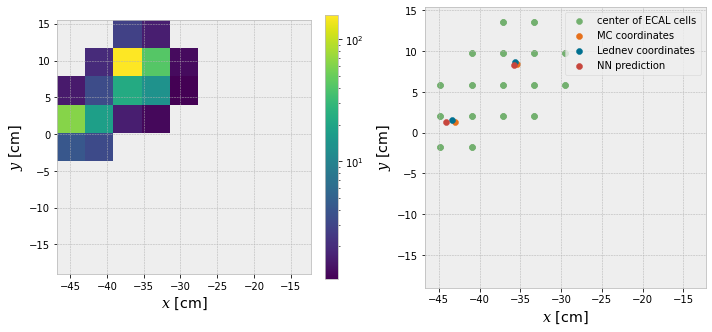

4


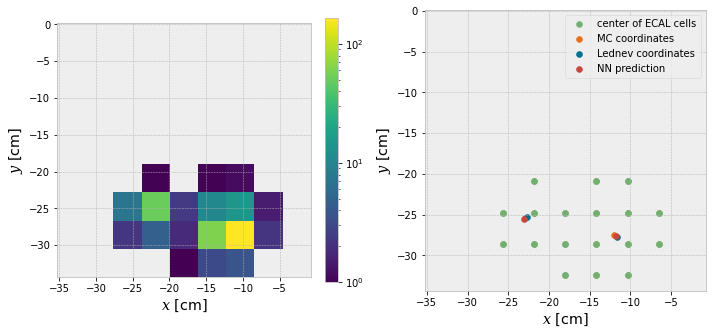

5


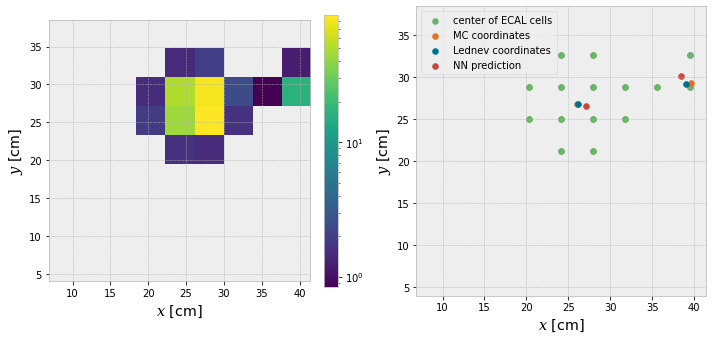

6


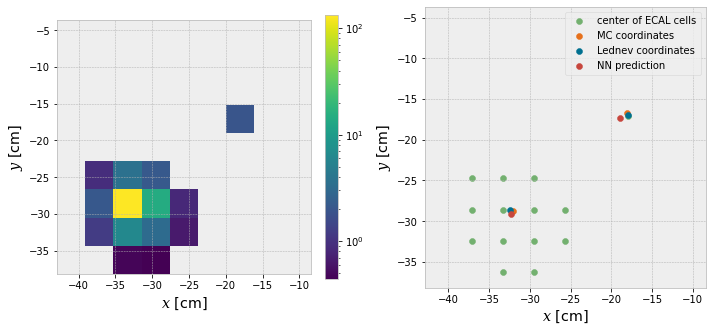

7


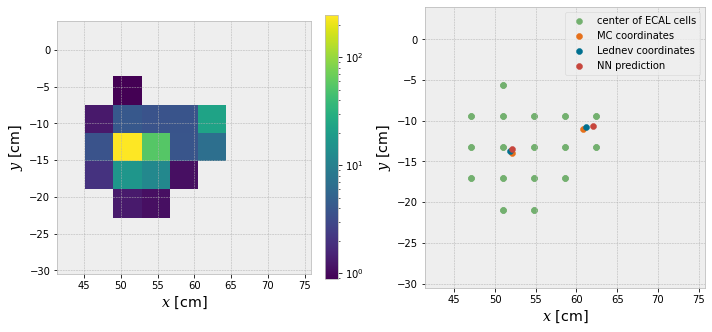

8


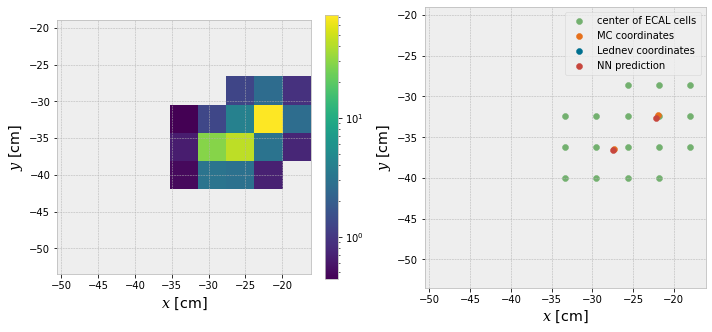

9


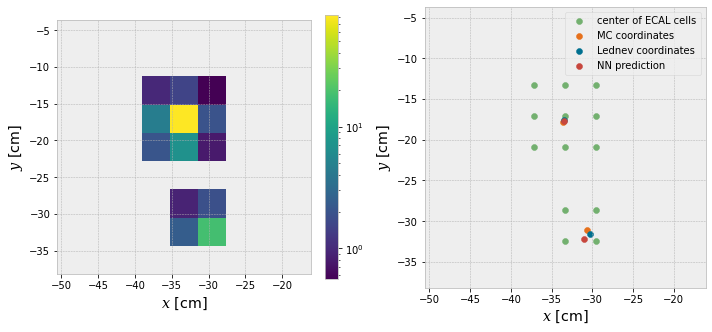

10


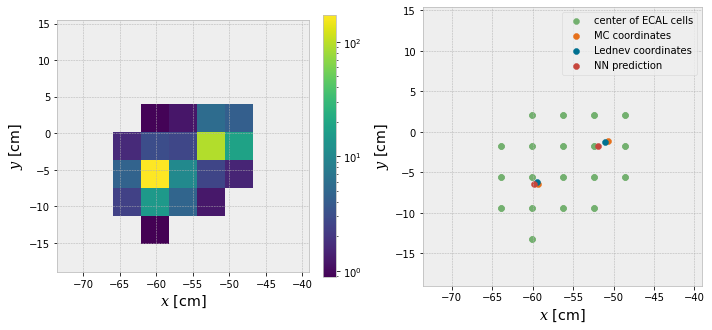

11


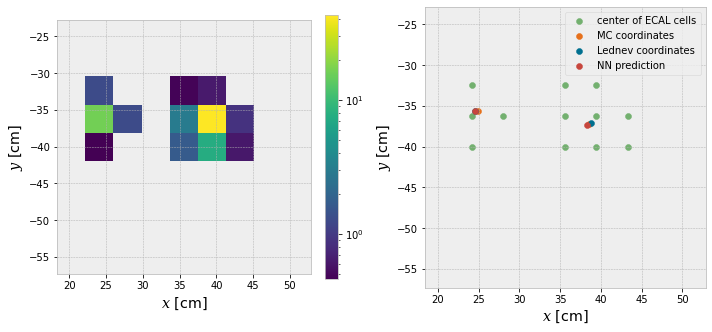

12


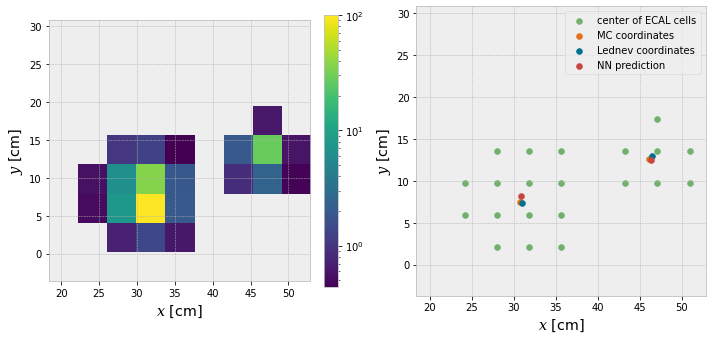

13


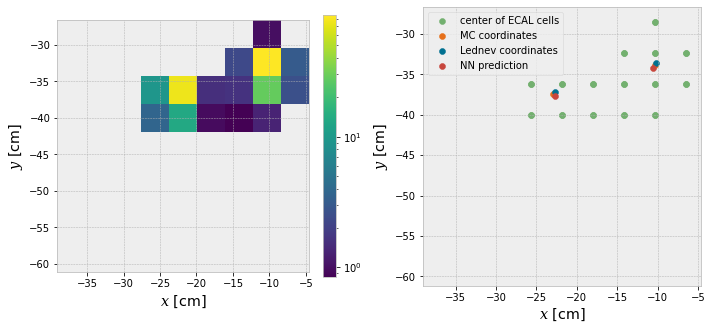

14


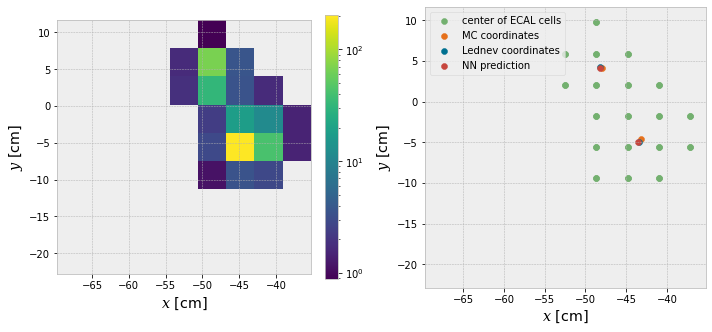

15


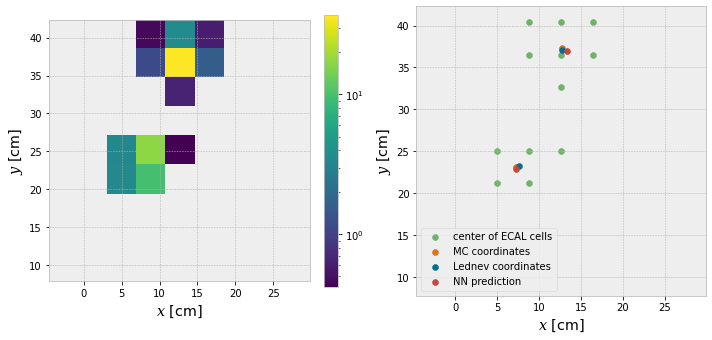

16


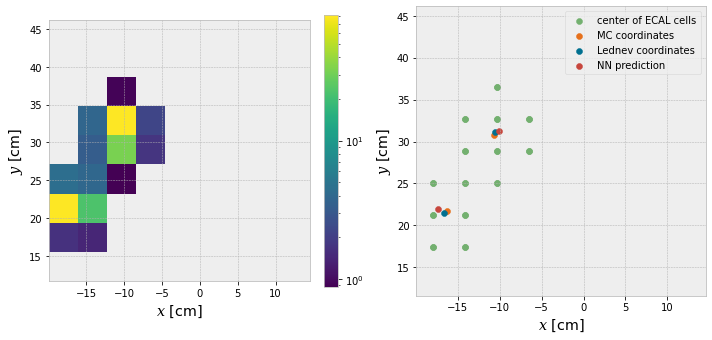

17


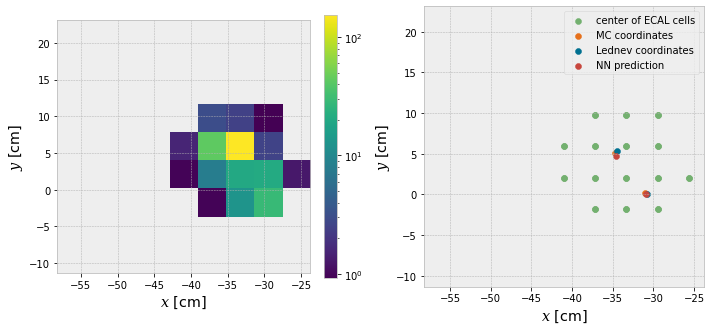

18


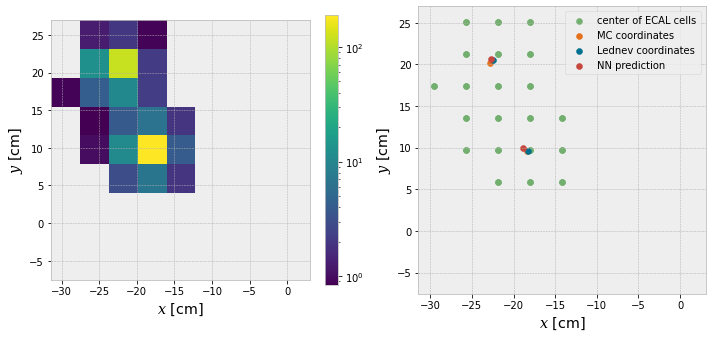

19


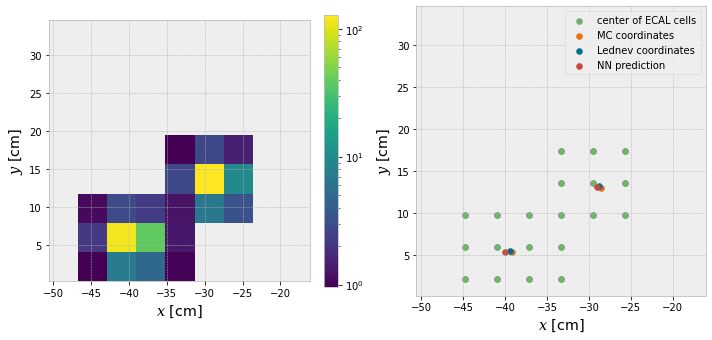

20


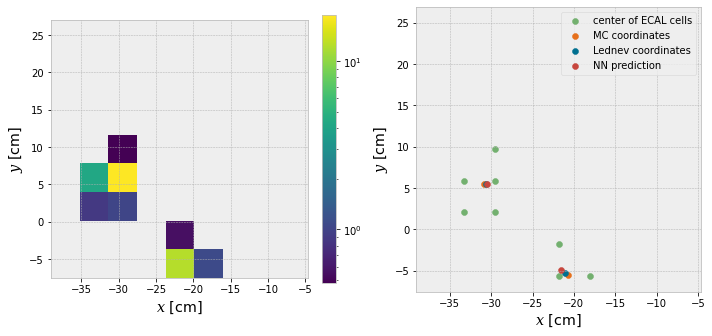

21


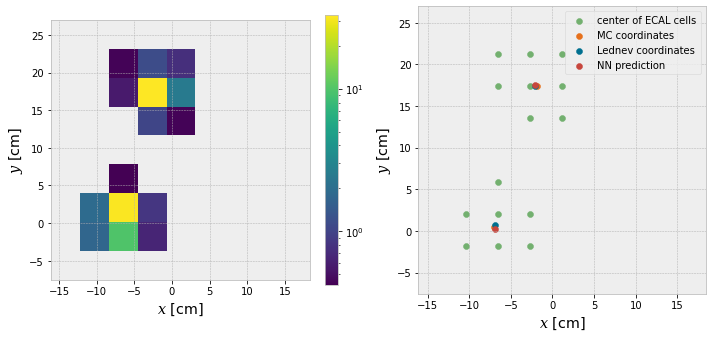

22


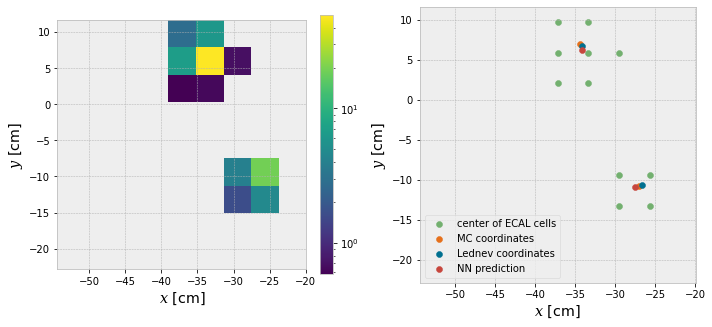

23


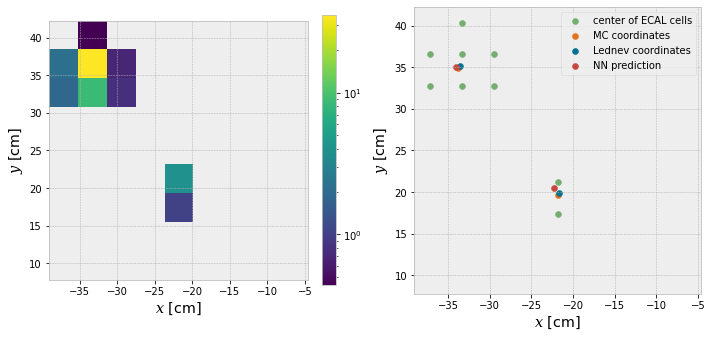

24


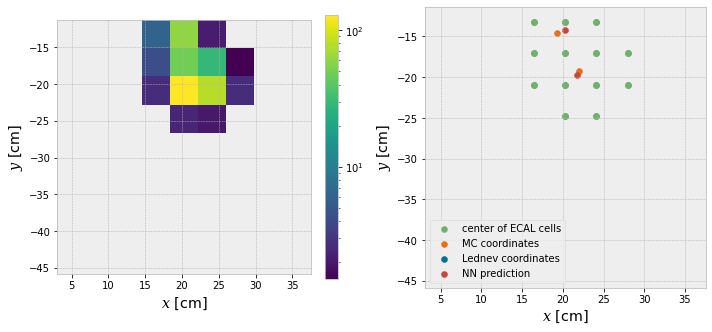

25


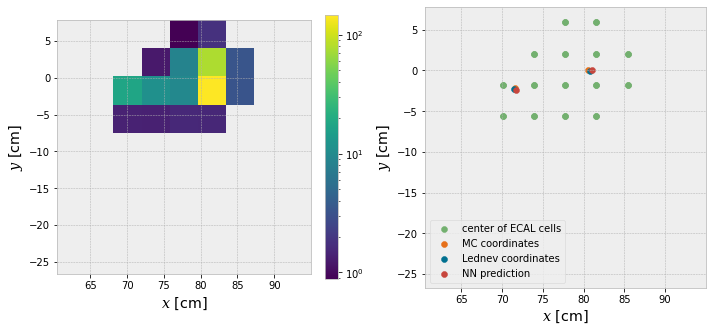

26


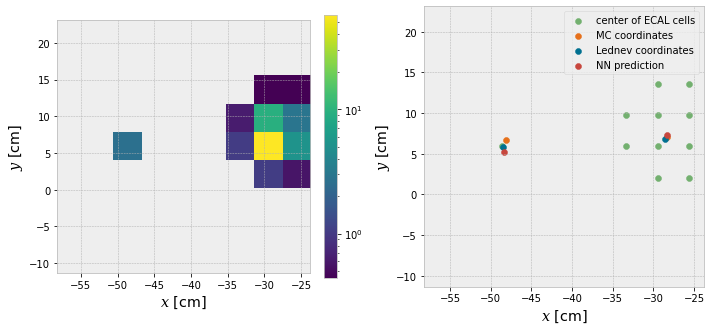

27


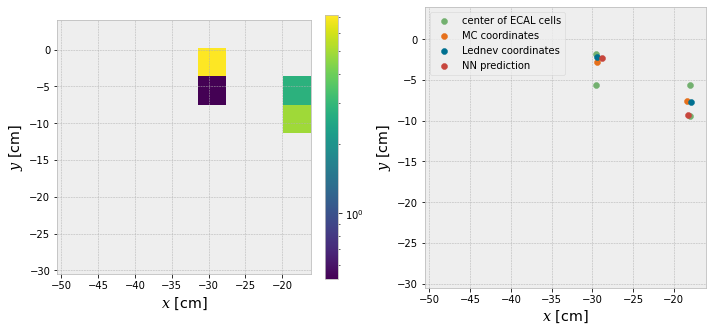

28


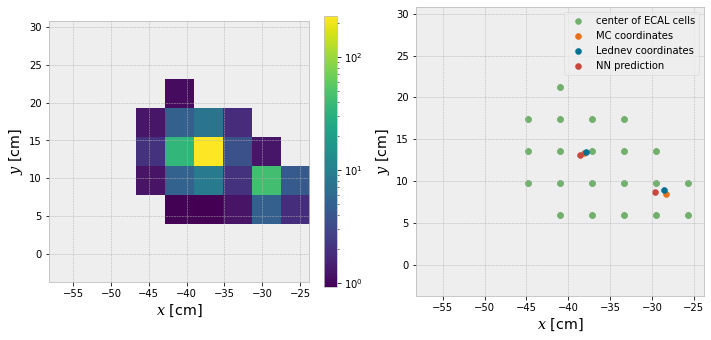

29


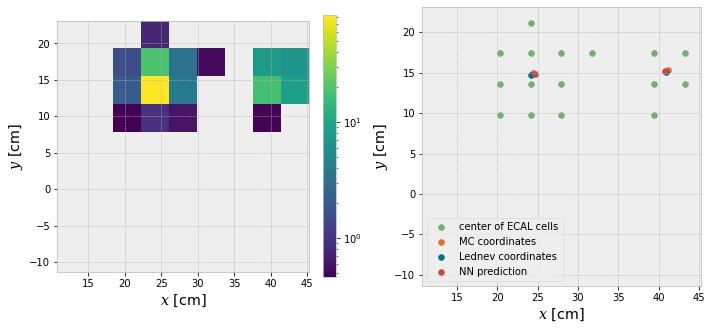

30


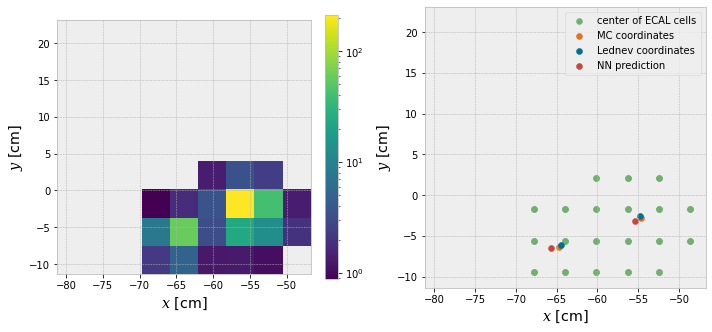

31


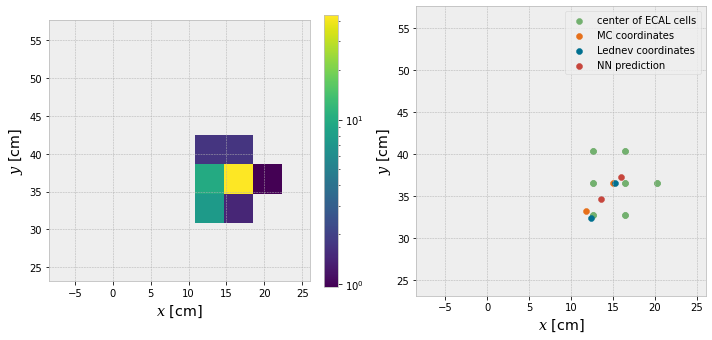

32


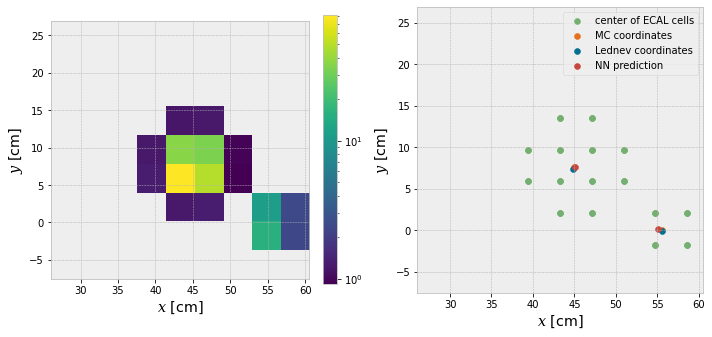

33


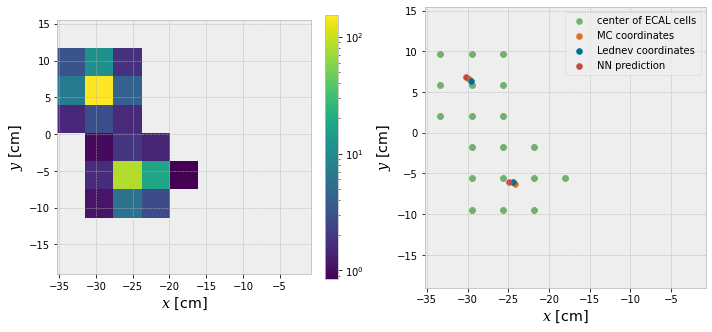

34


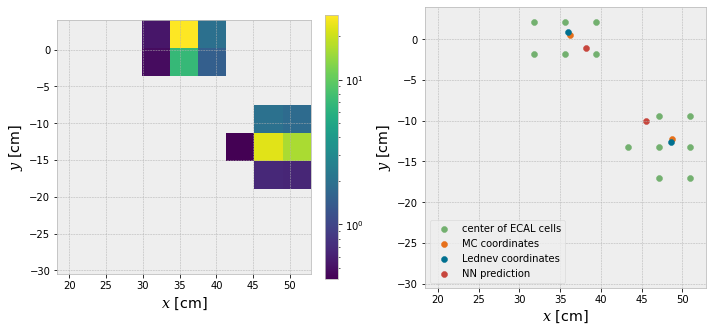

35


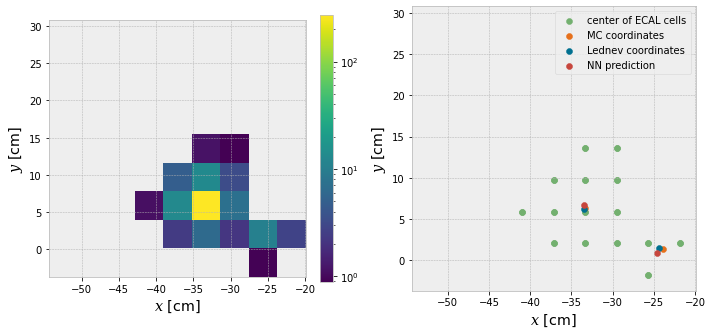

36


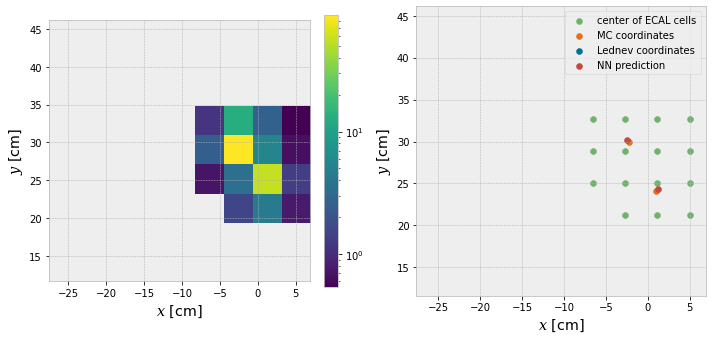

37


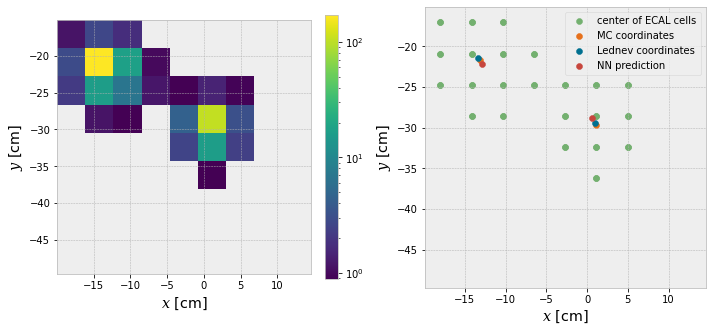

38


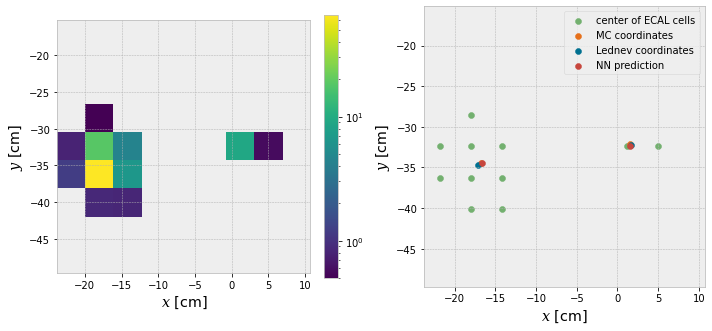

39


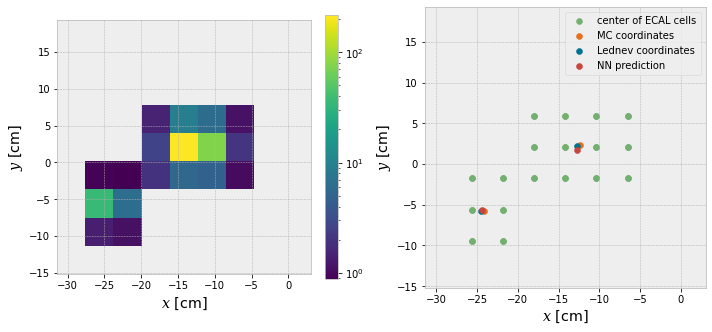

40


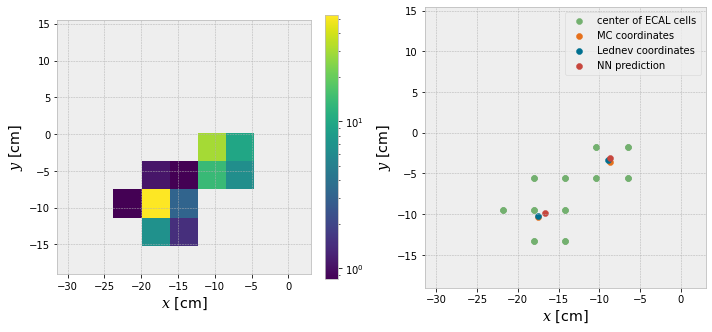

41


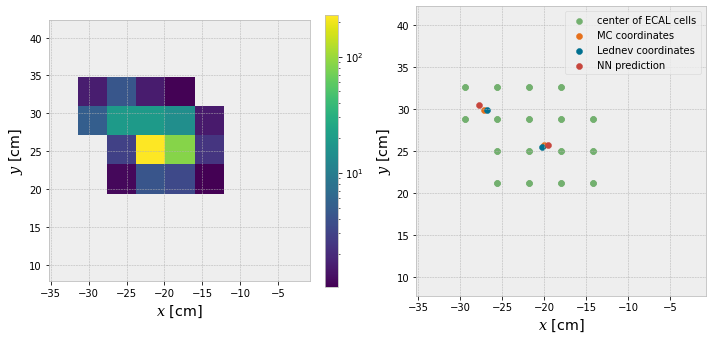

42


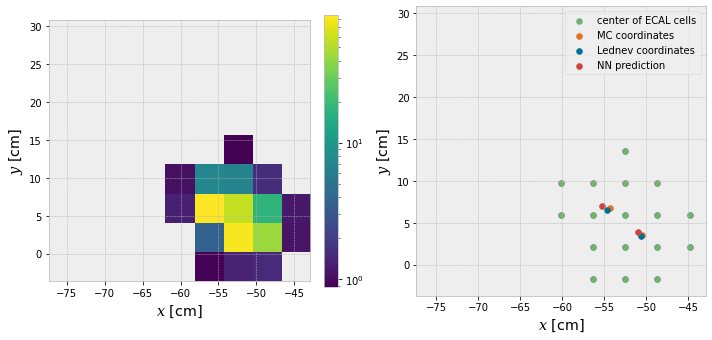

43


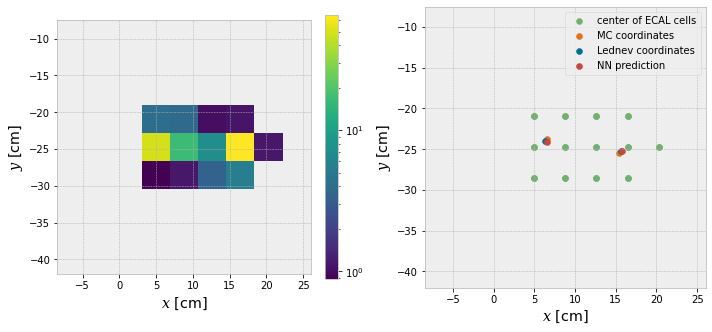

44


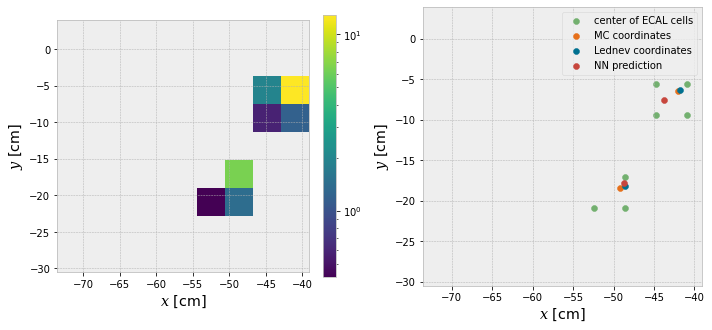

45


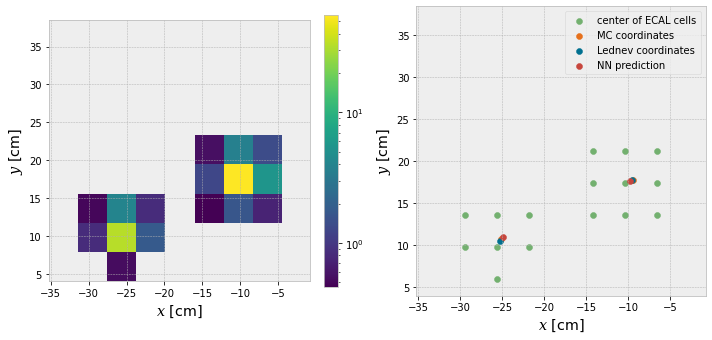

46


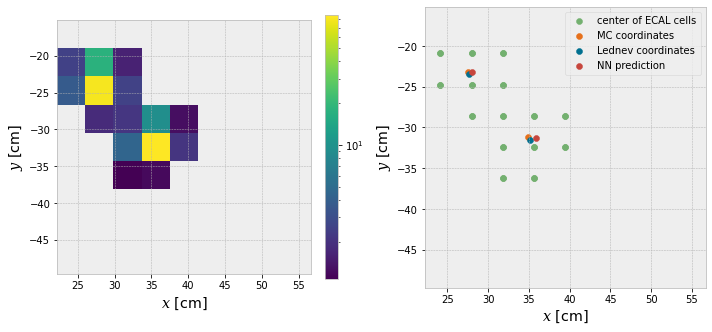

47


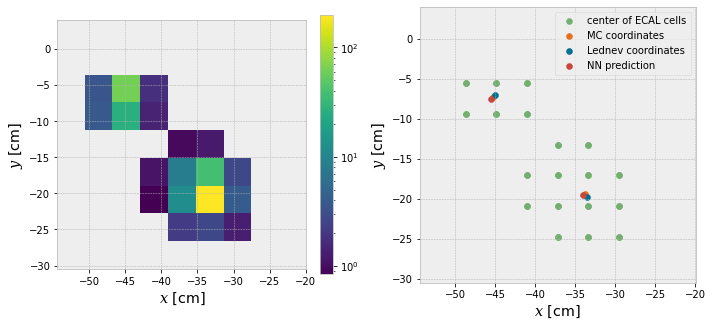

48


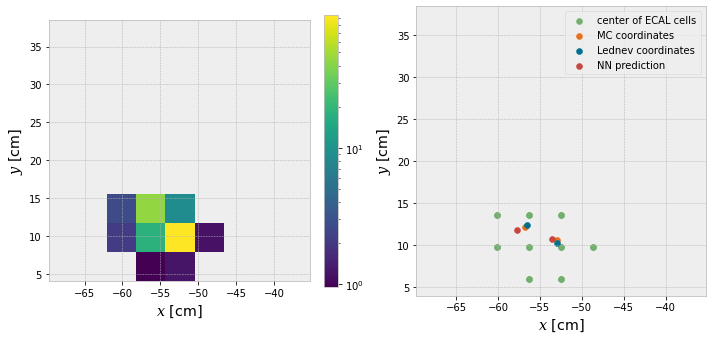

49


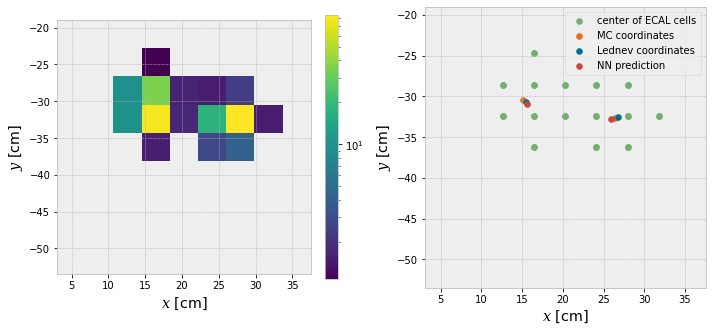

50


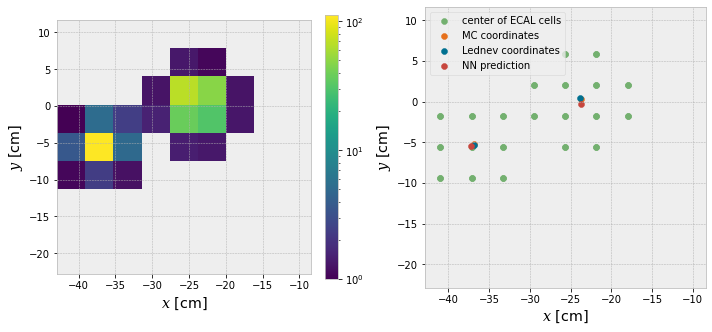

51


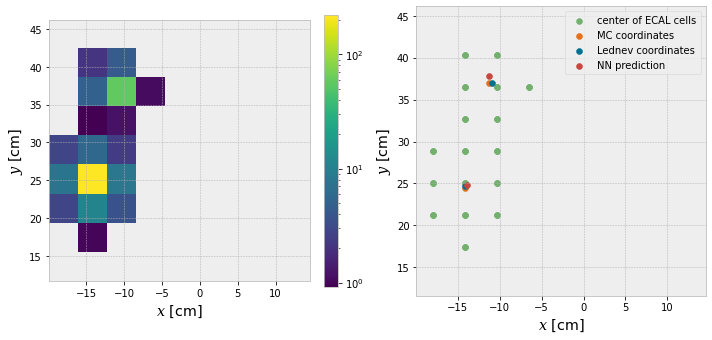

52


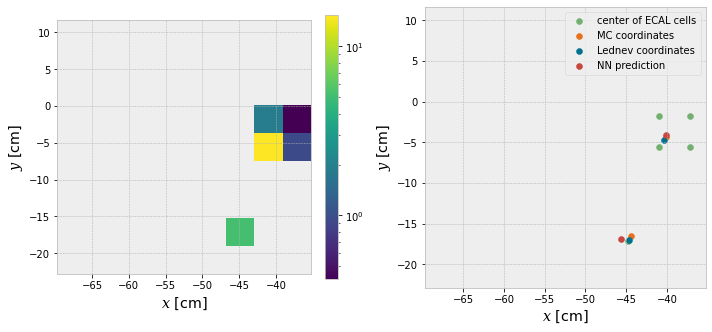

53


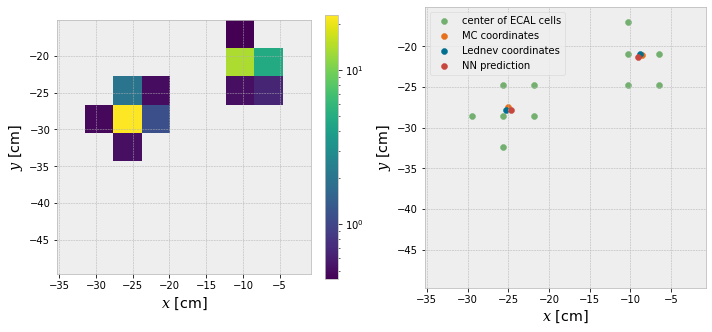

54


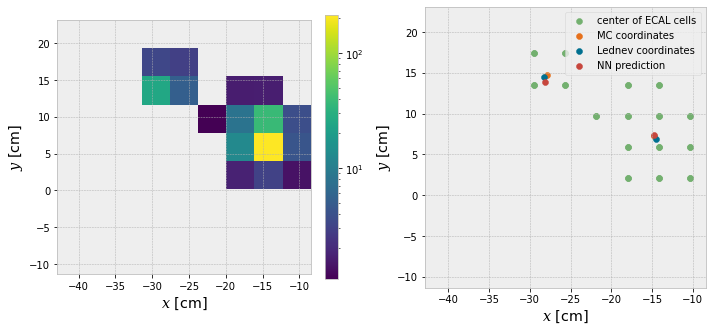

55


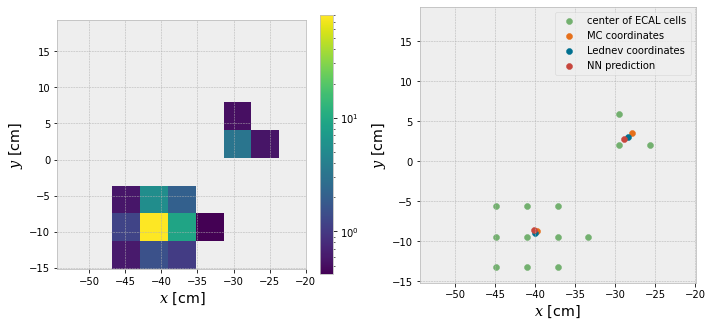

56


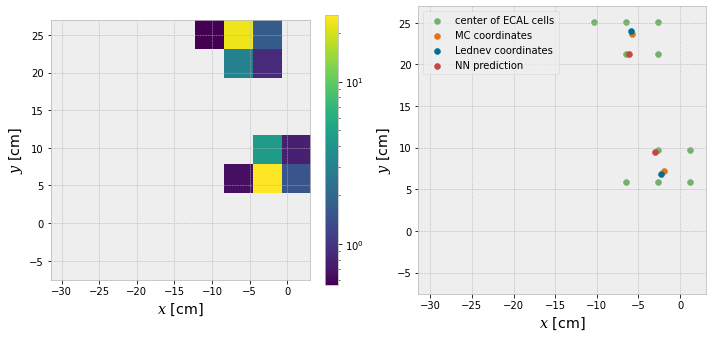

57


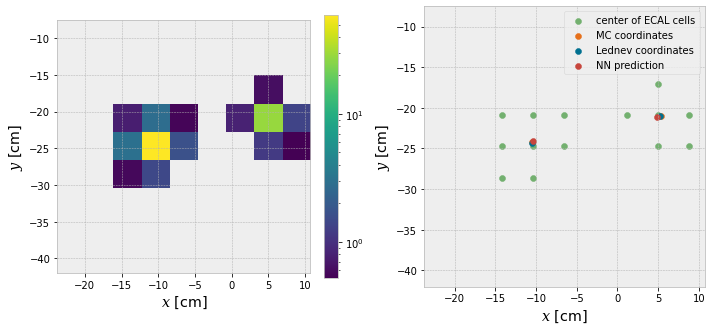

58


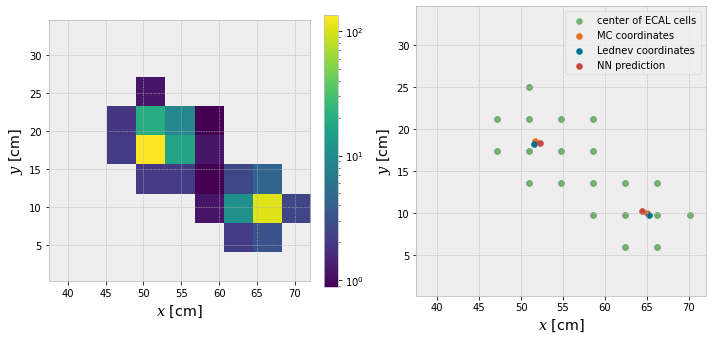

59


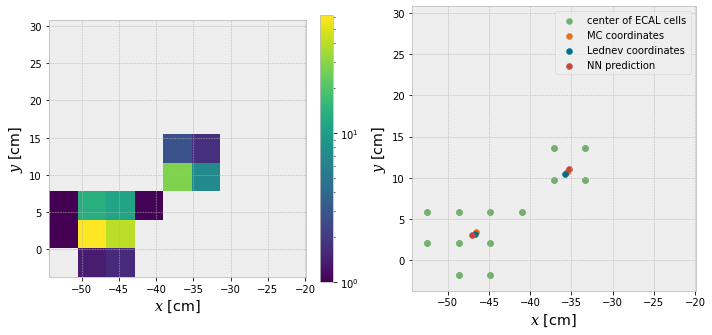

60


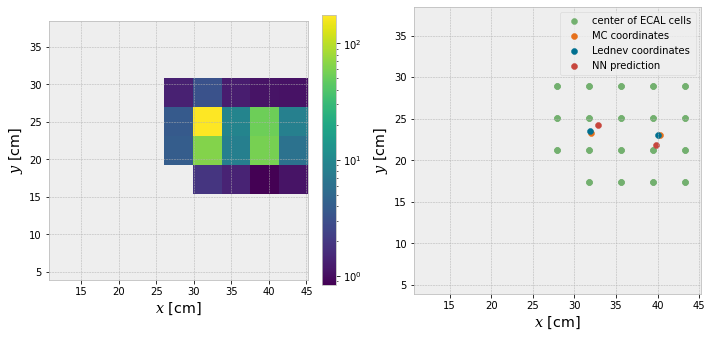

61


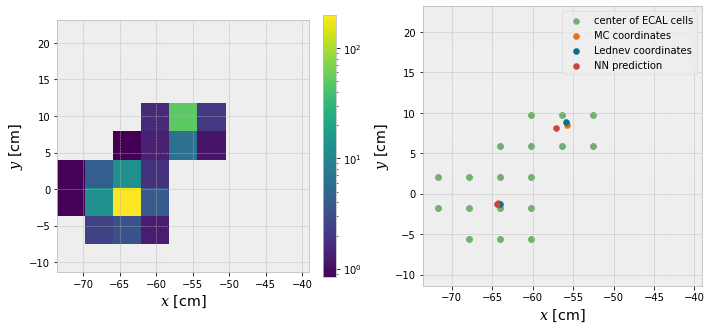

62


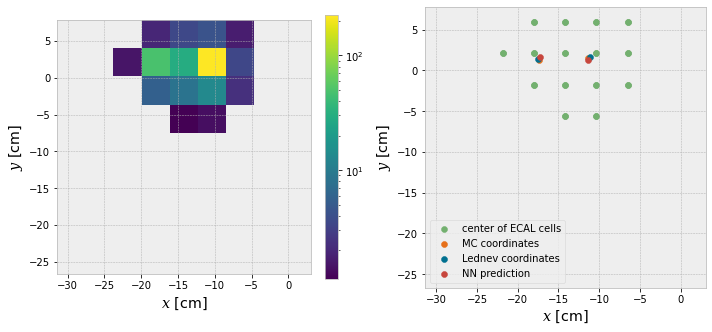

63


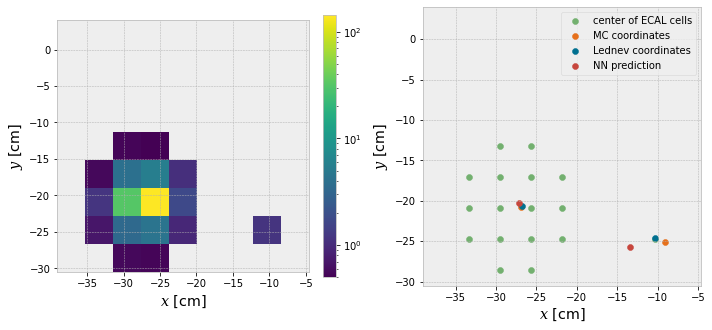

64


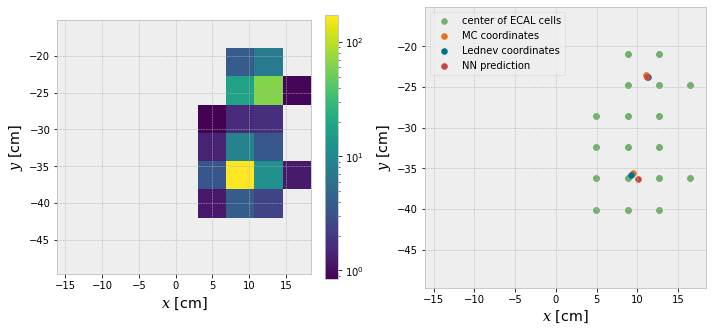

65


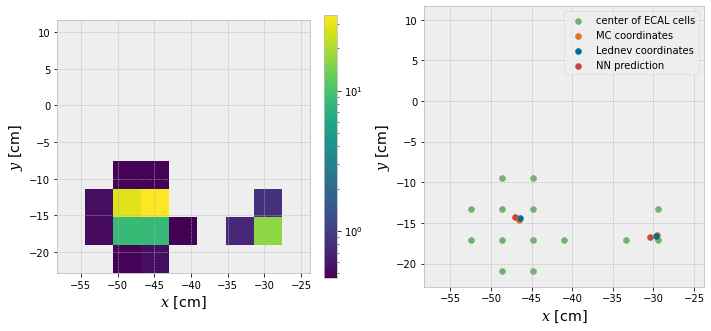

66


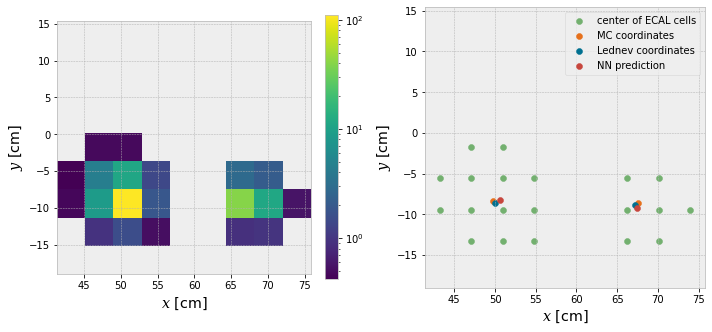

67


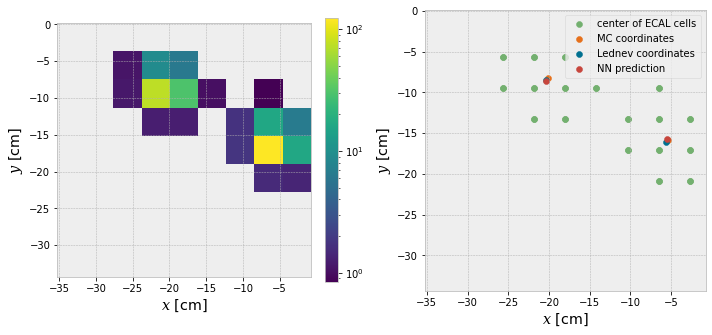

68


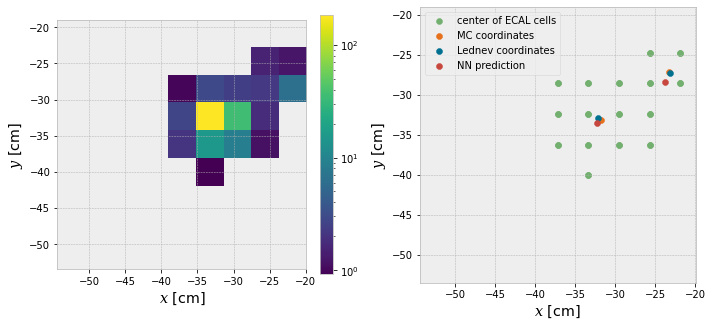

69


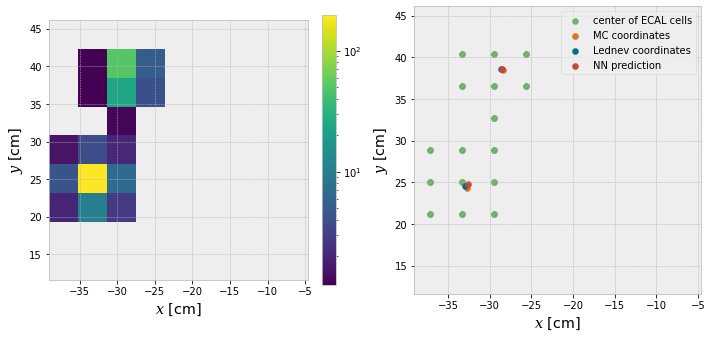

70


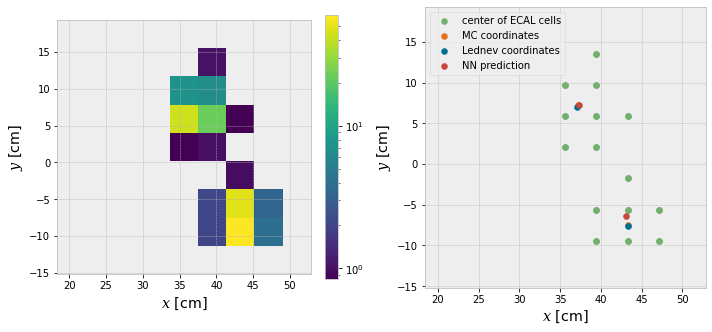

71


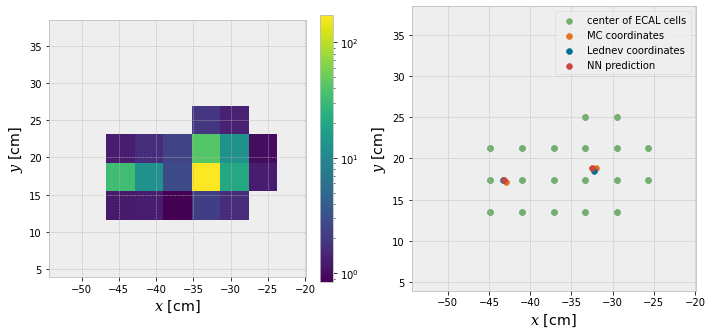

72


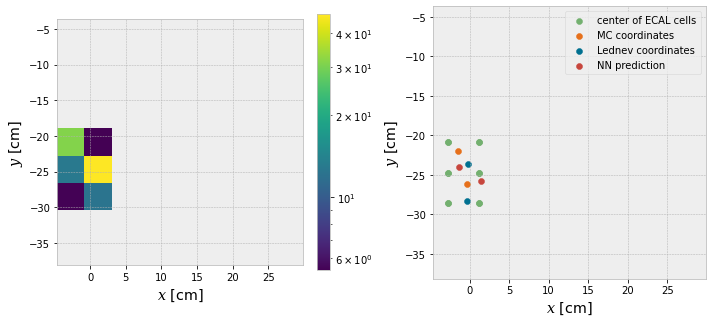

73


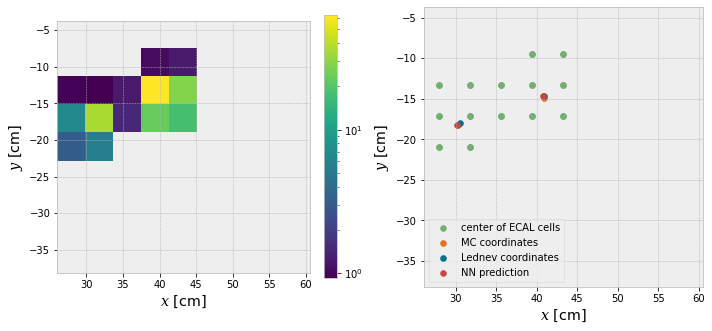

74


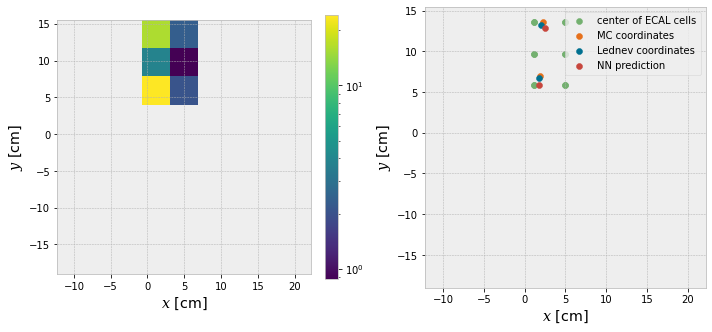

75


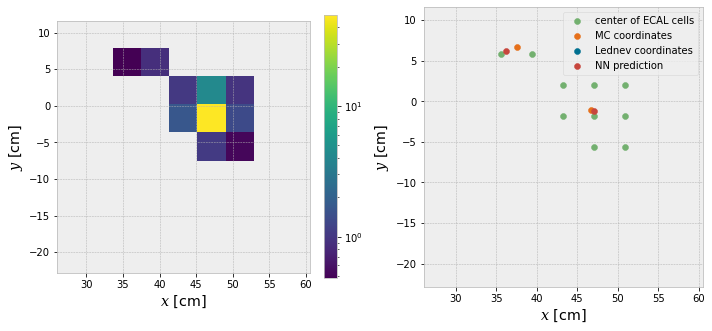

76


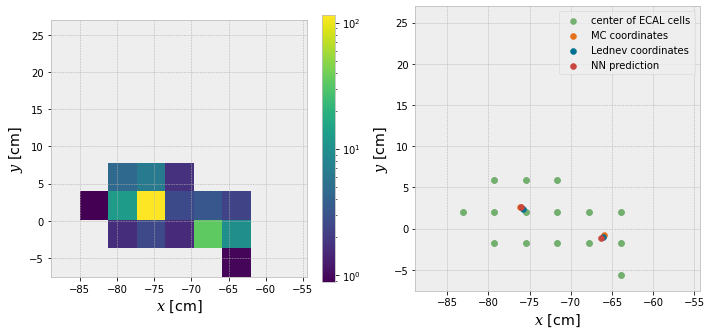

77


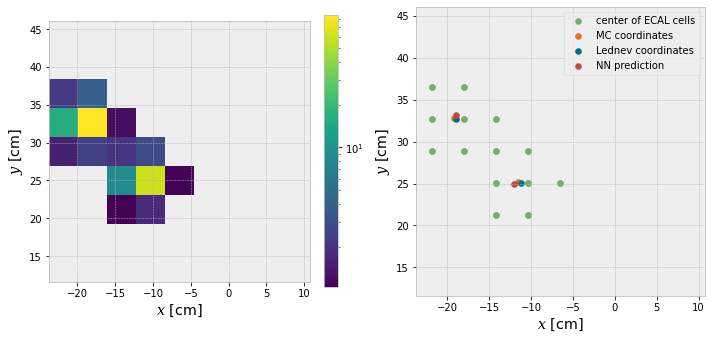

78


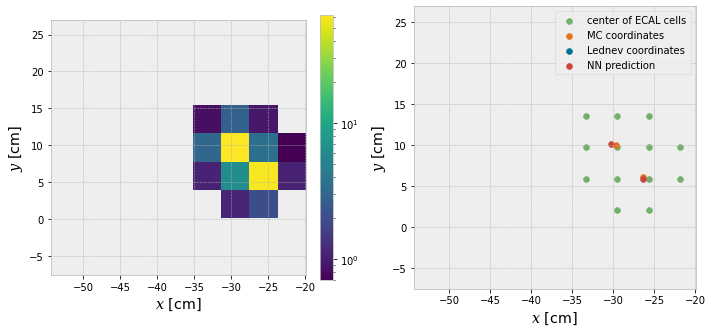

79


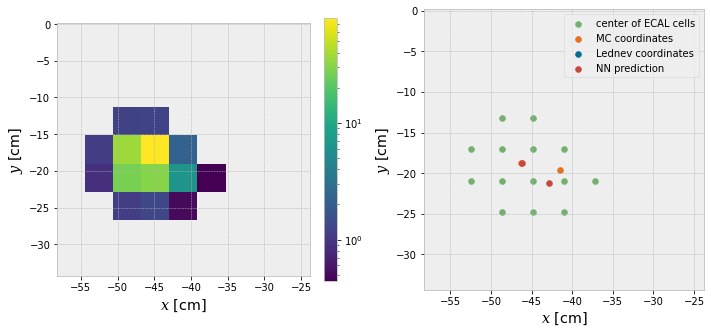

80


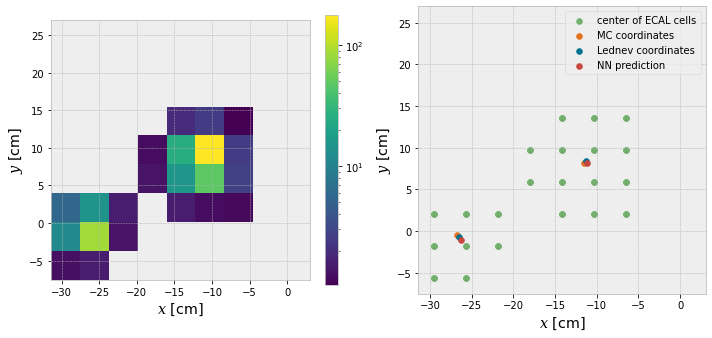

81


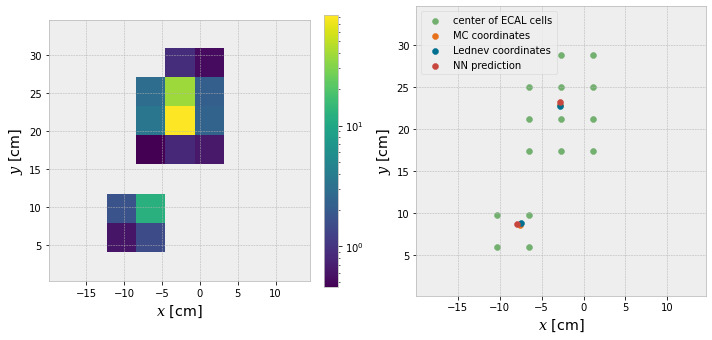

82


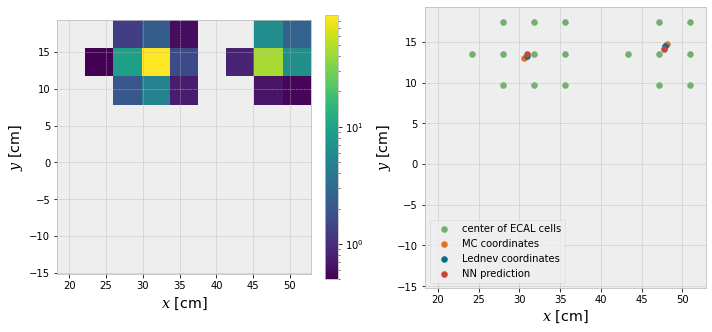

83


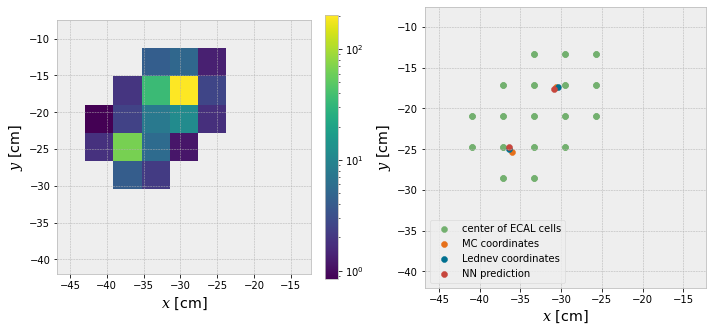

84


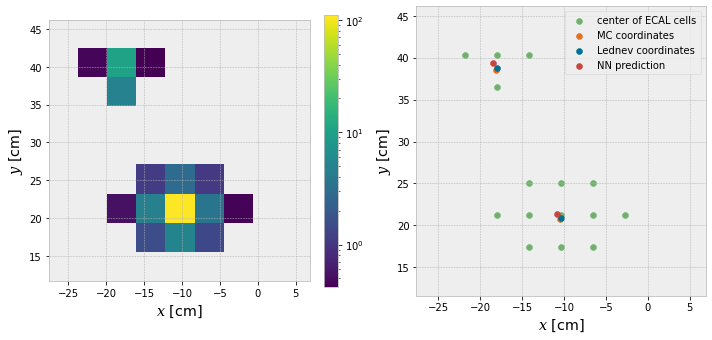

85


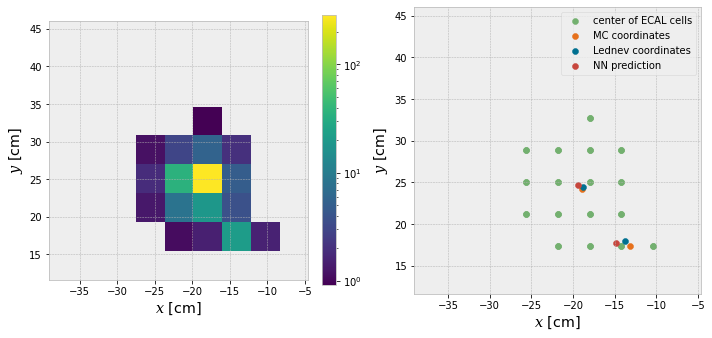

86


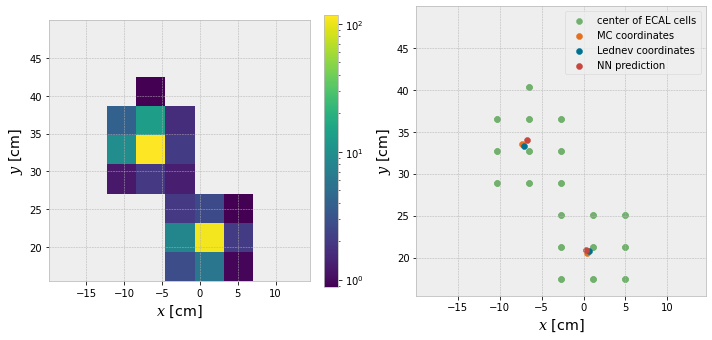

87


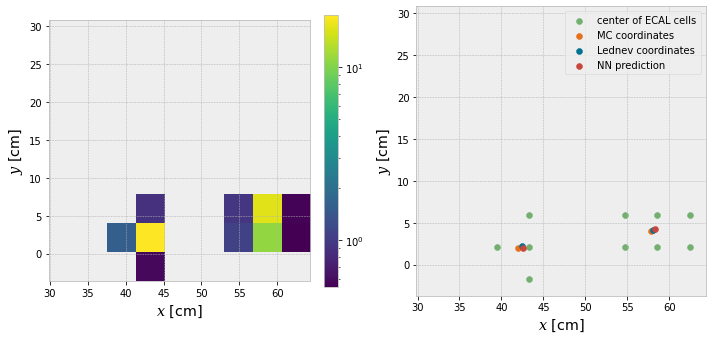

88


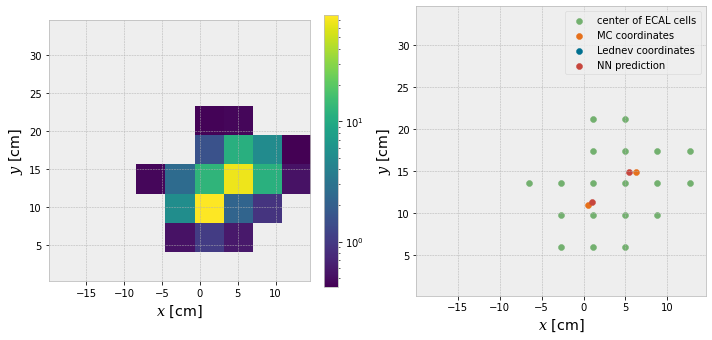

89


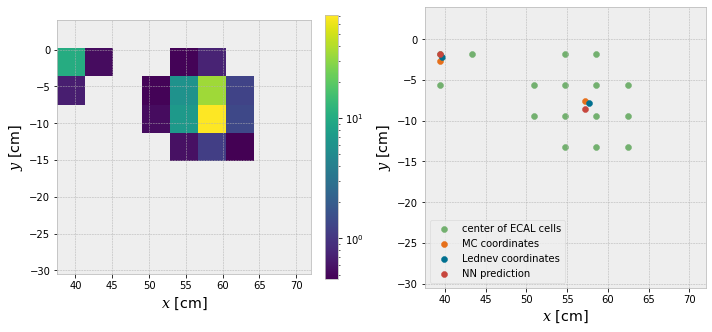

90


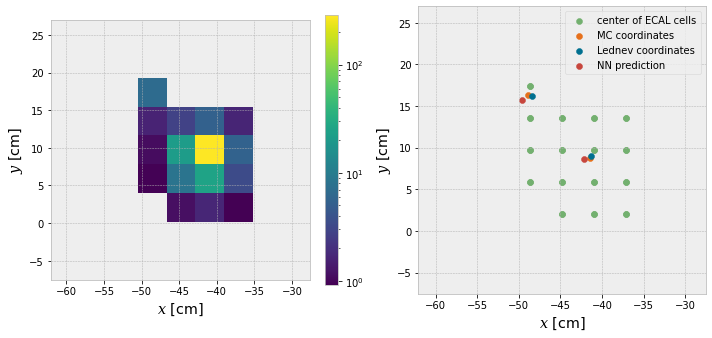

91


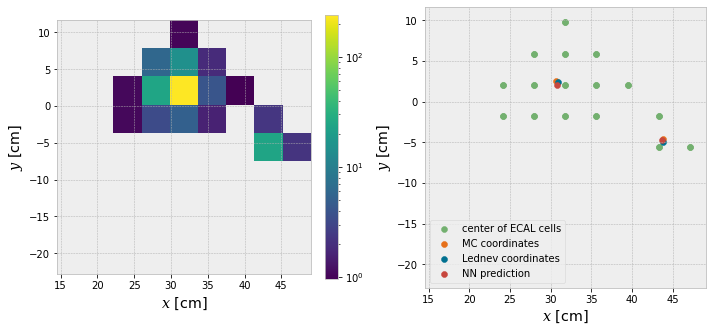

92


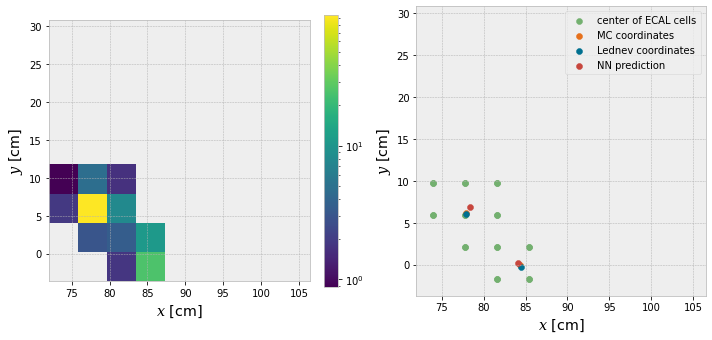

93


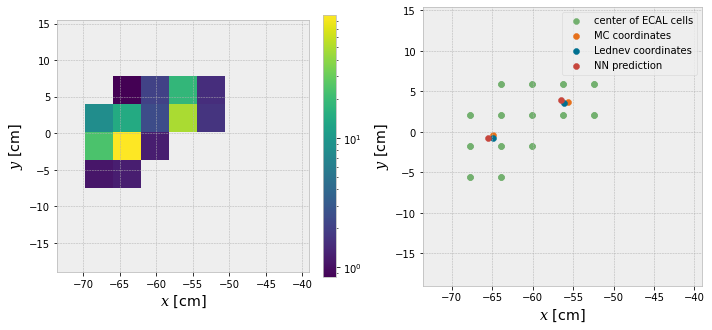

94


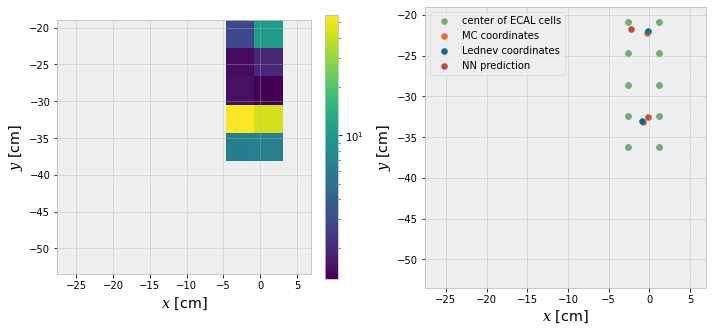

95


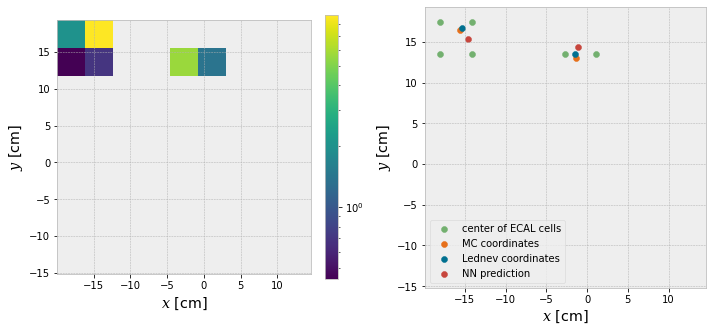

96


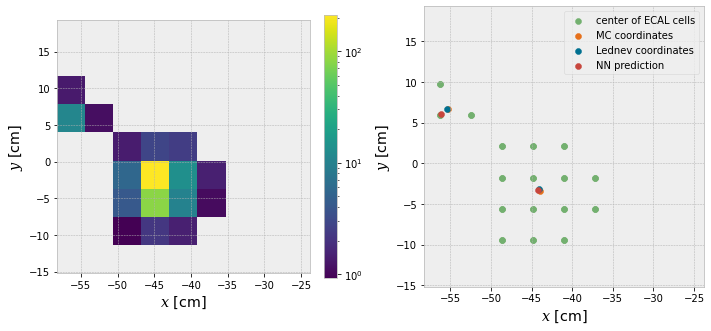

97


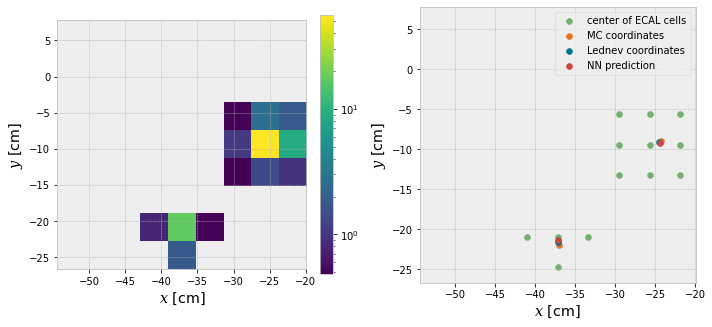

98


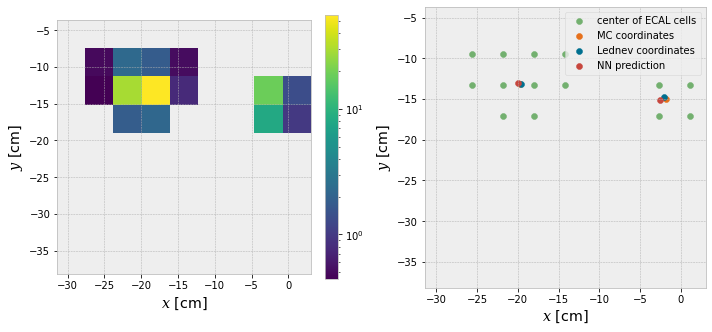

99


In [17]:
for i in range(100):
    ev.show_cluster_NNpred(i)
    print(i)

In [18]:
ev.make_markdown_tab(fit_param, lednev=True) # print mark down table

| | $\mu$ | $\sigma$ |
| --- | --- | --- |
| $x_1$ | $-0,006\pm0,002$ | $-0,490\pm0,002$ |
| $x_2$ | $-0,006\pm0,002$ | $-0,495\pm0,003$ |
| $y_1$ | $-0,039\pm0,002$ | $-0,425\pm0,003$ |
| $y_2$ | $-0,035\pm0,002$ | $-0,431\pm0,003$ |
| $E_1$ | $-0,001\pm0,000$ | $-0,036\pm0,000$ |
| $E_2$ | $-0,001\pm0,000$ | $-0,037\pm0,000$ |


| | $\mu$ | $\sigma$ |
| --- | --- | --- |
| $x_1$ | $-0,006\pm0,002$ | $-0,490\pm0,002$ |
| $x_2$ | $-0,006\pm0,002$ | $-0,495\pm0,003$ |
| $y_1$ | $-0,039\pm0,002$ | $-0,425\pm0,003$ |
| $y_2$ | $-0,035\pm0,002$ | $-0,431\pm0,003$ |
| $E_1$ | $-0,001\pm0,000$ | $-0,036\pm0,000$ |
| $E_2$ | $-0,001\pm0,000$ | $-0,037\pm0,000$ |

<h2> Let's do some analysis... </h2>

First look at energies that are more than one sigma away.

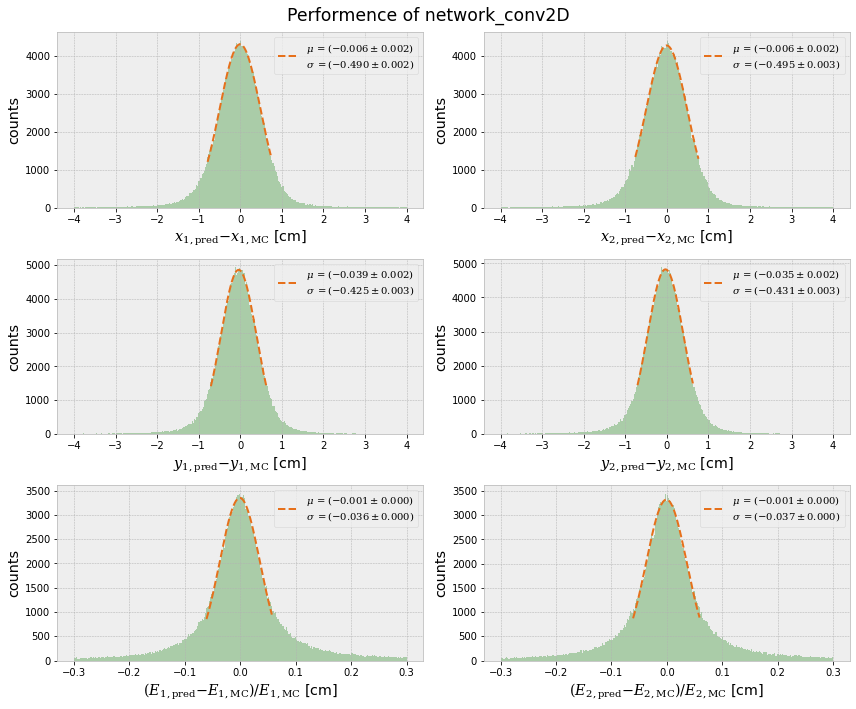

In [34]:
fit_param = ev.show_hist_NN(figsave=(False, "network_" + 'conv2D'))

In [35]:
sig_x1 = unp.nominal_values(fit_param[1])
sig_x2 = unp.nominal_values(fit_param[3])
sig_y1 = unp.nominal_values(fit_param[5])
sig_y2 = unp.nominal_values(fit_param[7])
sig_E1 = unp.nominal_values(fit_param[9])
sig_E2 = unp.nominal_values(fit_param[11])

In [36]:
print(sig_E1, sig_E2)

-0.03637954464953639 -0.03678888521708764


In [37]:
rel_E1 = (ev.E1 - ev.E1_t) / ev.E1_t
rel_E2 = (ev.E2 - ev.E2_t) / ev.E2_t

In [38]:
ind_E1_bad = np.where(abs(rel_E1) > abs(sig_E1))
ind_E2_bad = np.where(abs(rel_E2) > abs(sig_E2))
print(len(ind_E1_bad[0]), len(ind_E2_bad[0]))

106931 106603


106931.0


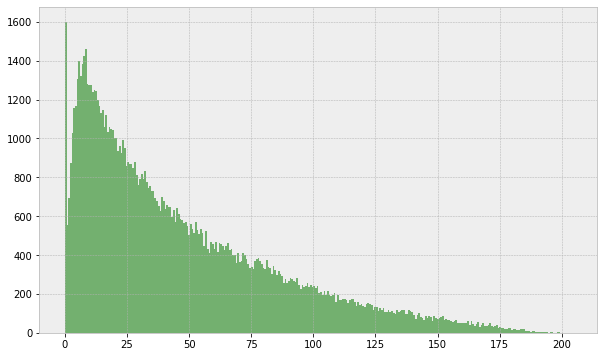

In [43]:
plt.rcParams["figure.figsize"] = (10, 6)
counts, bins, _ = plt.hist(ev.E1[ind_E1_bad])
print(np.sum(counts))
plt.show()

106603.0


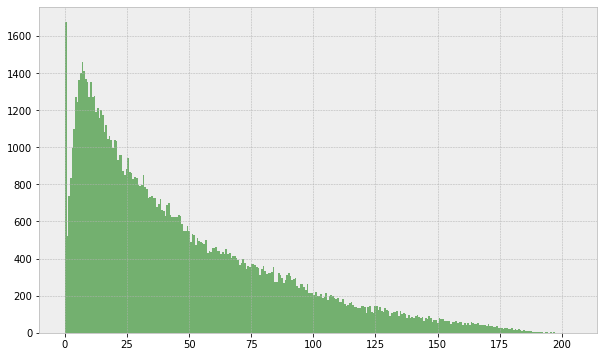

In [44]:
plt.rcParams["figure.figsize"] = (10, 6)
counts, bins, _ = plt.hist(ev.E2[ind_E2_bad])
print(np.sum(counts))
plt.show()

ok let's get serious

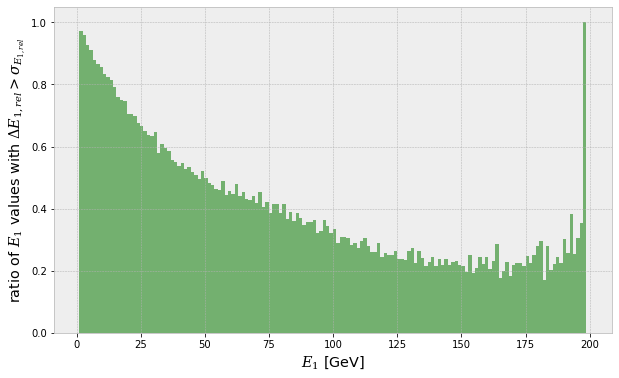

In [52]:
b = 150

hist_E1_t, bin_E1_t = np.histogram(ev.E1_t, bins=b)
hist_E1_bad, bins = np.histogram(ev.E1_t[ind_E1_bad], bins=b)
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel("$E_1 $ [GeV]")
plt.ylabel("ratio of $E_1$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")
plt.show()

/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


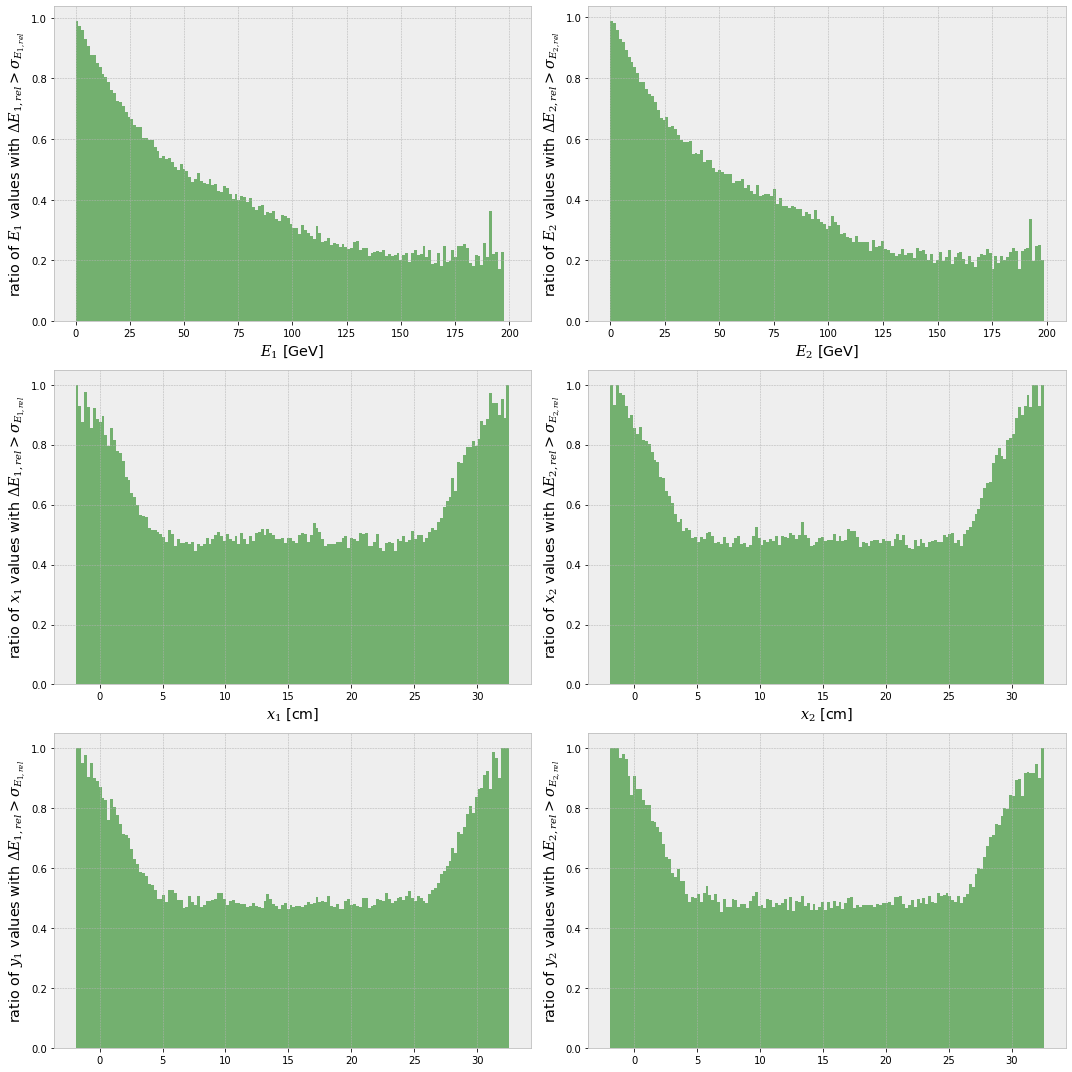

In [86]:
plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(ev.E1_t, bins=b, range=(0, 200))
hist_E1_bad, bins = np.histogram(ev.E1_t[ind_E1_bad], bins=b, range=(0, 200))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel("$E_1 $ [GeV]")
plt.ylabel("ratio of $E_1$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(ev.x1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x1_bad, bins = np.histogram(ev.x1_t[ind_E1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel("$x_1 $ [cm]")
plt.ylabel("ratio of $x_1$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(ev.y1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y1_bad, bins = np.histogram(ev.y1_t[ind_E1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.ylabel("$y_1 $ [cm]")
plt.ylabel("ratio of $y_1$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(ev.E2_t, bins=b, range=(0, 200))
hist_E2_bad, bins = np.histogram(ev.E2_t[ind_E2_bad], bins=b, range=(0, 200))
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel("$E_2 $ [GeV]")
plt.ylabel("ratio of $E_2$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(ev.x2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x2_bad, bins = np.histogram(ev.x2_t[ind_E2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel("$x_2 $ [cm]")
plt.ylabel("ratio of $x_2$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(ev.y2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y2_bad, bins = np.histogram(ev.y2_t[ind_E2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.ylabel("$y_2 $ [cm]")
plt.ylabel("ratio of $y_2$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.tight_layout()
plt.show()

/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<BarContainer object of 150 artists>

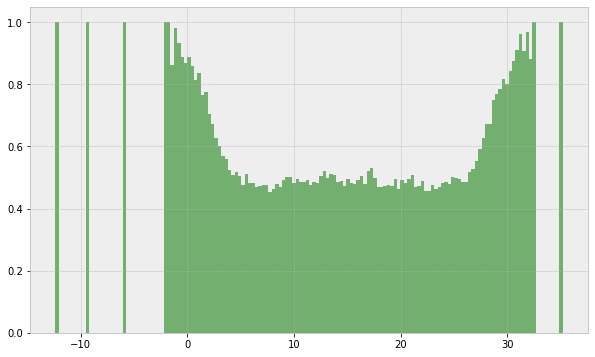

In [59]:
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0])

In [60]:
ev.x1_t.min()

-12.380625005497198

In [79]:
ind = np.where(ev.x1_t < -ipd.cellsize/2)
print(ind)
print(ipd.cellsize/2)

(array([ 79249, 121137, 155201, 176639]),)
1.915


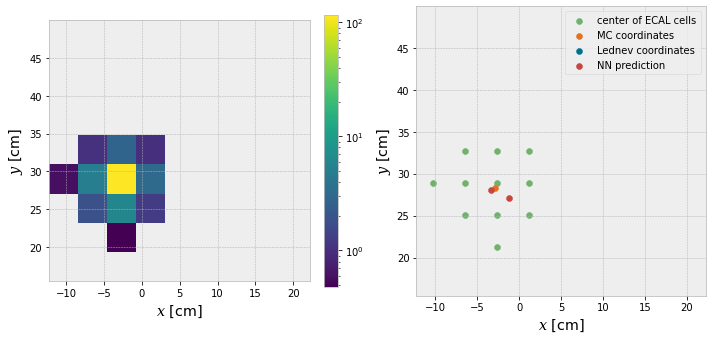

79249
[-10.345  17.385]
-9.352284349471432
[-19.69728435  -2.8661402 ] [38.34296157 28.30748686]


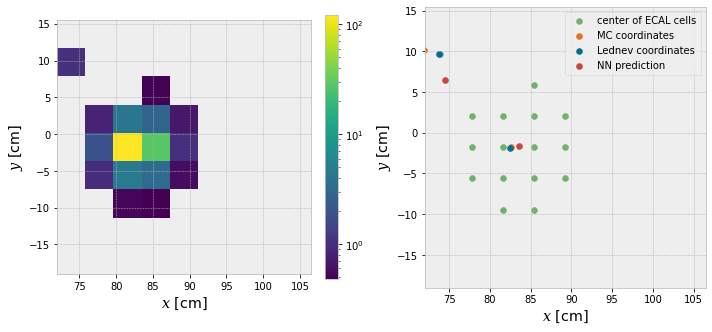

121137
[ 73.915 -17.085]
-2.0265660704724695
[71.88843393 82.57942618] [10.13965767 -1.79133651]


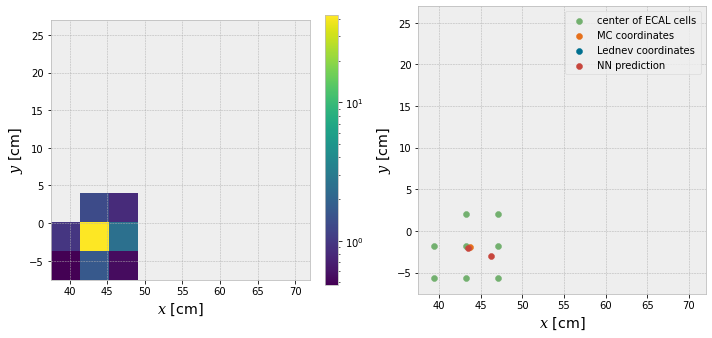

155201
[39.445 -5.595]
-12.380625005497198
[27.06437499 43.66734956] [-3.67617805 -1.97247497]


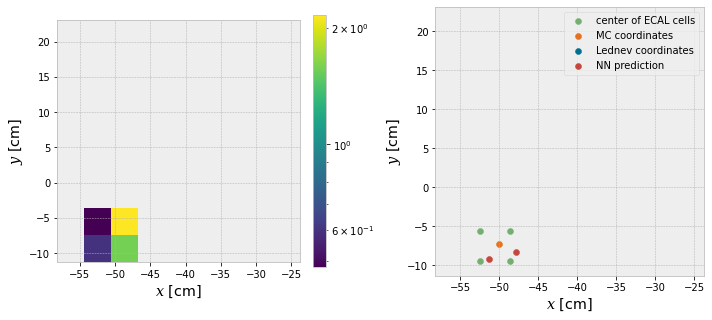

176639
[-56.305  -9.425]
-5.83976439000552
[-62.14476439 -50.08729927] [ 3.97683012 -7.33256825]


In [78]:
for i in ind[0]:
    ev.show_cluster_NNpred(i)
    print(i)
    print(ipd.coord_v[i])
    print(ev.x1_t[i])
    print(ipd.x_truth_veri[i], ipd.y_truth_veri[i])

**to summarize:** es gibt ein paar Cluster wos nur einen cluster gibt... aber bei 3 aus mehreren 100 tausend ist das ok.

<h2> Now the same but for $x$ values that are more than one $\sigma$ away.

In [87]:
diff_x1 = (ev.x1 - ev.x1_t) 
diff_x2 = (ev.x2 - ev.x2_t) 

ind_x1_bad = np.where(abs(diff_x1) > abs(sig_x1))
ind_x2_bad = np.where(abs(diff_x2) > abs(sig_x2))
print(len(ind_x1_bad[0]), len(ind_x2_bad[0]))

75076 74601


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


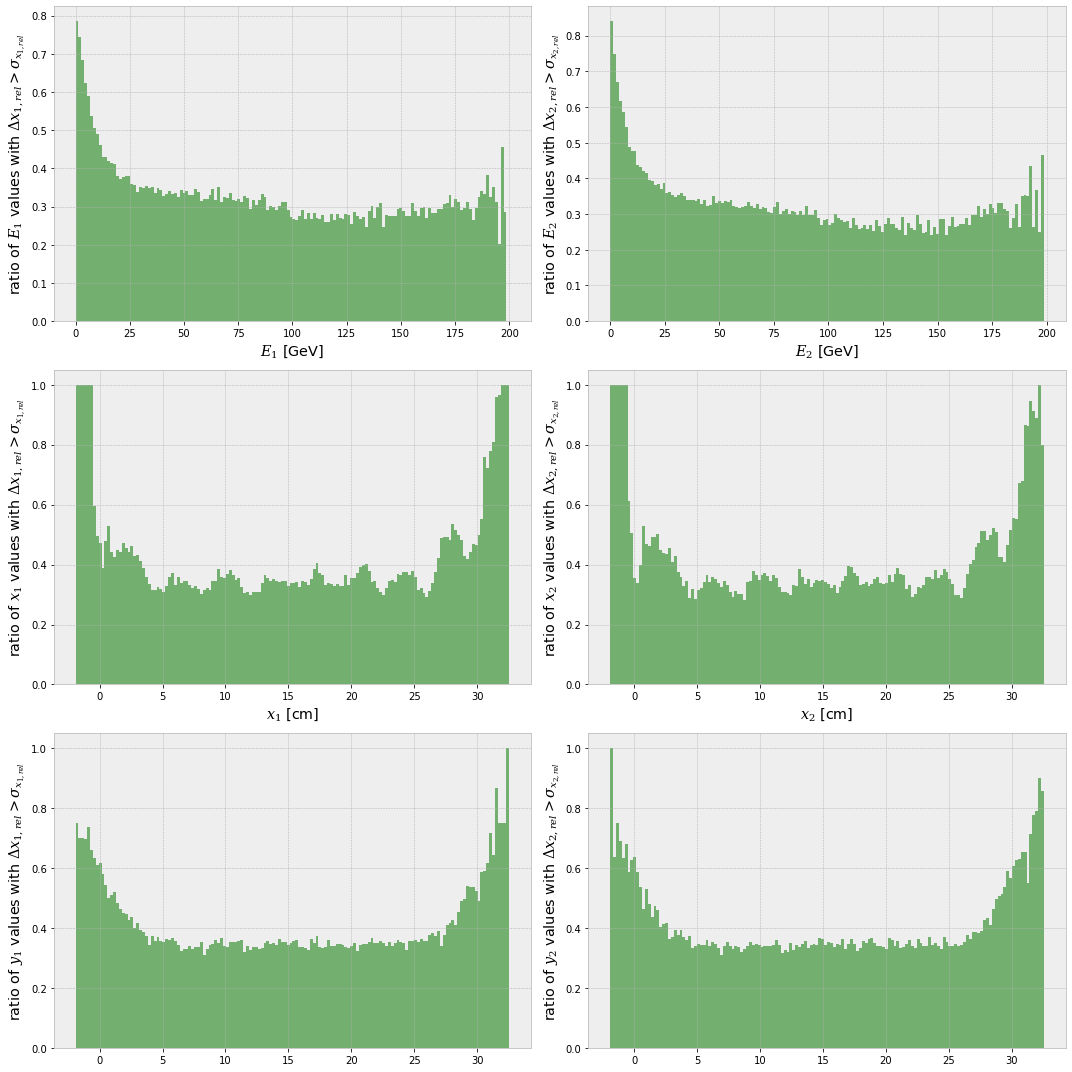

In [88]:
plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(ev.E1_t, bins=b, range=(0, 200))
hist_E1_bad, bins = np.histogram(ev.E1_t[ind_x1_bad], bins=b, range=(0, 200))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel("$E_1 $ [GeV]")
plt.ylabel("ratio of $E_1$ values with $\Delta x_{1, rel} > \sigma_{x_{1, rel}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(ev.x1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x1_bad, bins = np.histogram(ev.x1_t[ind_x1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel("$x_1 $ [cm]")
plt.ylabel("ratio of $x_1$ values with $\Delta x_{1, rel} > \sigma_{x_{1, rel}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(ev.y1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y1_bad, bins = np.histogram(ev.y1_t[ind_x1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.ylabel("$y_1 $ [cm]")
plt.ylabel("ratio of $y_1$ values with $\Delta x_{1, rel} > \sigma_{x_{1, rel}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(ev.E2_t, bins=b, range=(0, 200))
hist_E2_bad, bins = np.histogram(ev.E2_t[ind_x2_bad], bins=b, range=(0, 200))
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel("$E_2 $ [GeV]")
plt.ylabel("ratio of $E_2$ values with $\Delta x_{2, rel} > \sigma_{x_{2, rel}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(ev.x2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x2_bad, bins = np.histogram(ev.x2_t[ind_x2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel("$x_2 $ [cm]")
plt.ylabel("ratio of $x_2$ values with $\Delta x_{2, rel} > \sigma_{x_{2, rel}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(ev.y2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y2_bad, bins = np.histogram(ev.y2_t[ind_x2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.ylabel("$y_2 $ [cm]")
plt.ylabel("ratio of $y_2$ values with $\Delta x_{2, rel} > \sigma_{x_{2, rel}} $")

plt.tight_layout()
plt.show()

<h2> And for $y$

In [89]:
diff_y1 = (ev.y1 - ev.y1_t) 
diff_y2 = (ev.y2 - ev.y2_t) 

ind_y1_bad = np.where(abs(diff_y1) > abs(sig_y1))
ind_y2_bad = np.where(abs(diff_y2) > abs(sig_y2))
print(len(ind_y1_bad[0]), len(ind_y2_bad[0]))

78865 77690


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


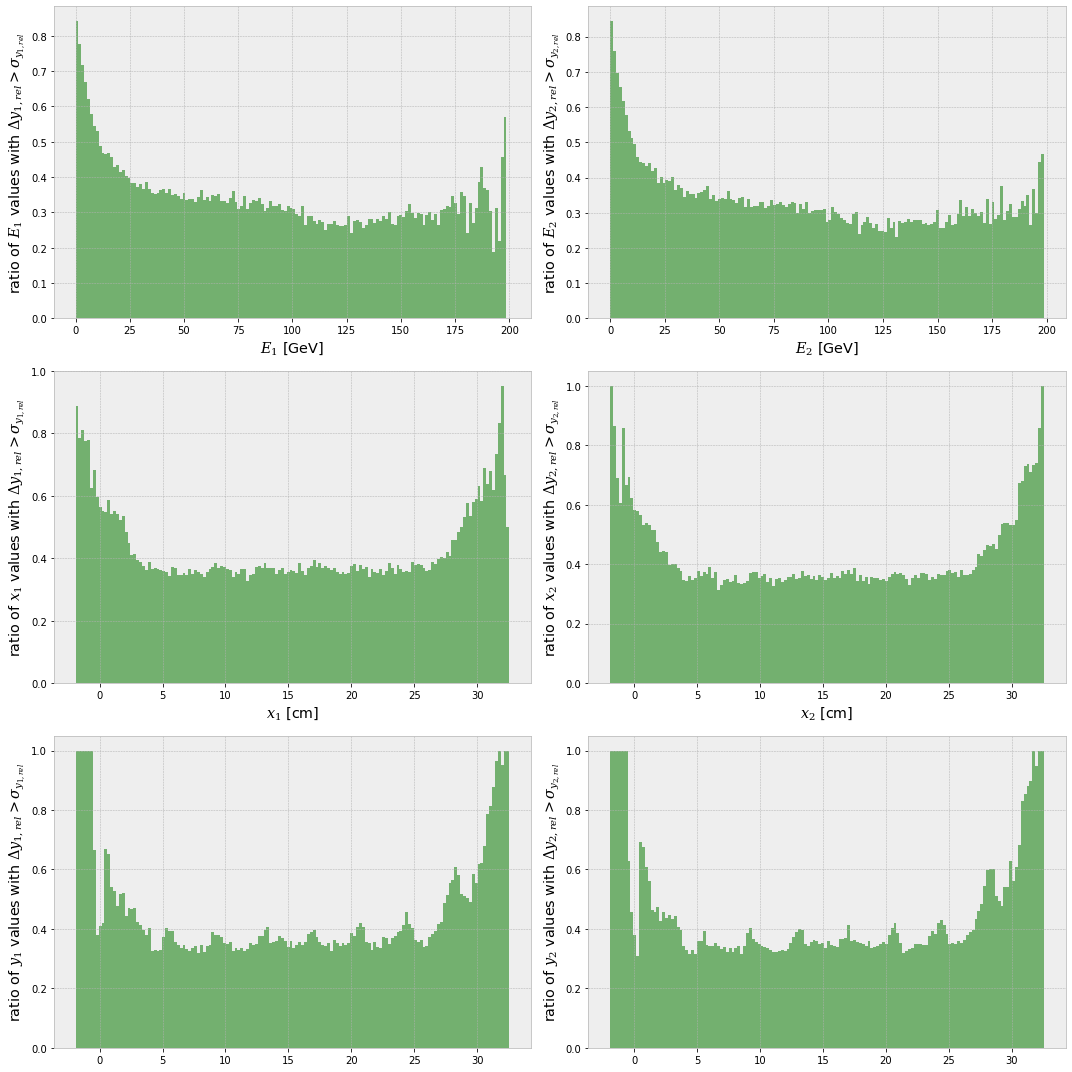

In [90]:
plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(ev.E1_t, bins=b, range=(0, 200))
hist_E1_bad, bins = np.histogram(ev.E1_t[ind_y1_bad], bins=b, range=(0, 200))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel("$E_1 $ [GeV]")
plt.ylabel("ratio of $E_1$ values with $\Delta y_{1, rel} > \sigma_{y_{1, rel}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(ev.x1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x1_bad, bins = np.histogram(ev.x1_t[ind_y1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel("$x_1 $ [cm]")
plt.ylabel("ratio of $x_1$ values with $\Delta y_{1, rel} > \sigma_{y_{1, rel}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(ev.y1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y1_bad, bins = np.histogram(ev.y1_t[ind_y1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.ylabel("$y_1 $ [cm]")
plt.ylabel("ratio of $y_1$ values with $\Delta y_{1, rel} > \sigma_{y_{1, rel}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(ev.E2_t, bins=b, range=(0, 200))
hist_E2_bad, bins = np.histogram(ev.E2_t[ind_y2_bad], bins=b, range=(0, 200))
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel("$E_2 $ [GeV]")
plt.ylabel("ratio of $E_2$ values with $\Delta y_{2, rel} > \sigma_{y_{2, rel}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(ev.x2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x2_bad, bins = np.histogram(ev.x2_t[ind_y2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel("$x_2 $ [cm]")
plt.ylabel("ratio of $x_2$ values with $\Delta y_{2, rel} > \sigma_{y_{2, rel}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(ev.y2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y2_bad, bins = np.histogram(ev.y2_t[ind_y2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.ylabel("$y_2 $ [cm]")
plt.ylabel("ratio of $y_2$ values with $\Delta y_{2, rel} > \sigma_{y_{2, rel}} $")

plt.tight_layout()
plt.show()

<h2> Und Winkel...?

In [92]:
# theta aus verification set...

theta_x1_t = np.arccos(ipd.momentum_v.T[0]/ (np.linalg.norm(ipd.momentum_v.T[:3].T, axis=1)))
theta_y1_t = np.arccos(ipd.momentum_v.T[1]/ (np.linalg.norm(ipd.momentum_v.T[:3].T, axis=1)))
theta_z1_t = np.arccos(ipd.momentum_v.T[2]/ (np.linalg.norm(ipd.momentum_v.T[:3].T, axis=1)))
theta_x2_t = np.arccos(ipd.momentum_v.T[0+3]/ (np.linalg.norm(ipd.momentum_v.T[3:].T, axis=1)))
theta_y2_t = np.arccos(ipd.momentum_v.T[1+3]/ (np.linalg.norm(ipd.momentum_v.T[3:].T, axis=1)))
theta_z2_t = np.arccos(ipd.momentum_v.T[2+3]/ (np.linalg.norm(ipd.momentum_v.T[3:].T, axis=1)))

/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


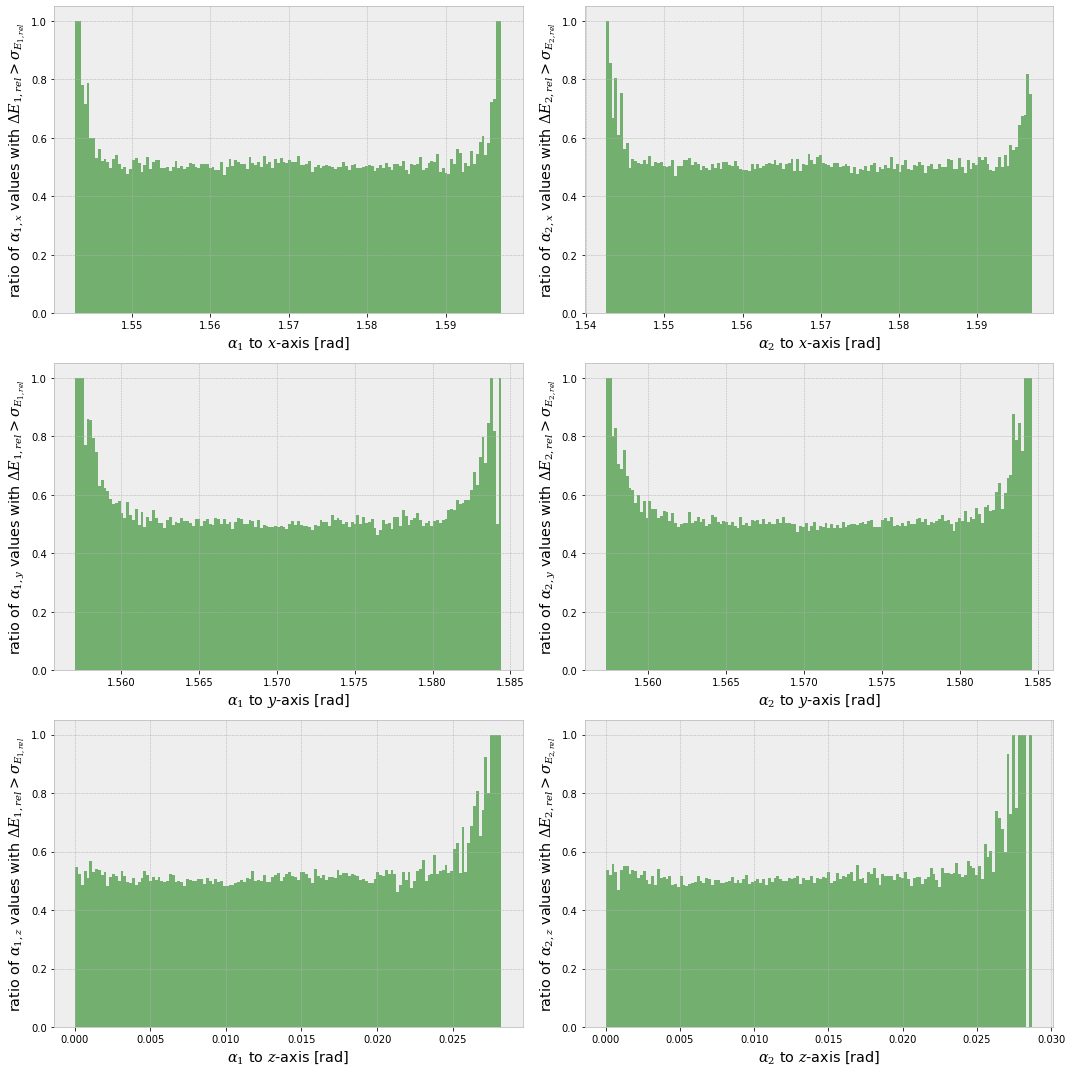

In [95]:
plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(theta_x1_t, bins=b)
hist_E1_bad, bins = np.histogram(theta_x1_t[ind_E1_bad], bins=b)
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, x}$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(theta_y1_t, bins=b)
hist_x1_bad, bins = np.histogram(theta_y1_t[ind_E1_bad], bins=b)
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, y}$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(theta_z1_t, bins=b)
hist_y1_bad, bins = np.histogram(theta_z1_t[ind_E1_bad], bins=b)
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, z}$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(theta_x2_t, bins=b)
hist_E2_bad, bins = np.histogram(theta_x2_t[ind_E2_bad], bins=b)
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, x}$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(theta_y2_t, bins=b)
hist_x2_bad, bins = np.histogram(theta_y2_t[ind_E2_bad], bins=b)
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, y}$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(theta_z2_t, bins=b)
hist_y2_bad, bins = np.histogram(theta_z2_t[ind_E2_bad], bins=b)
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, z}$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.tight_layout()
plt.show()


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


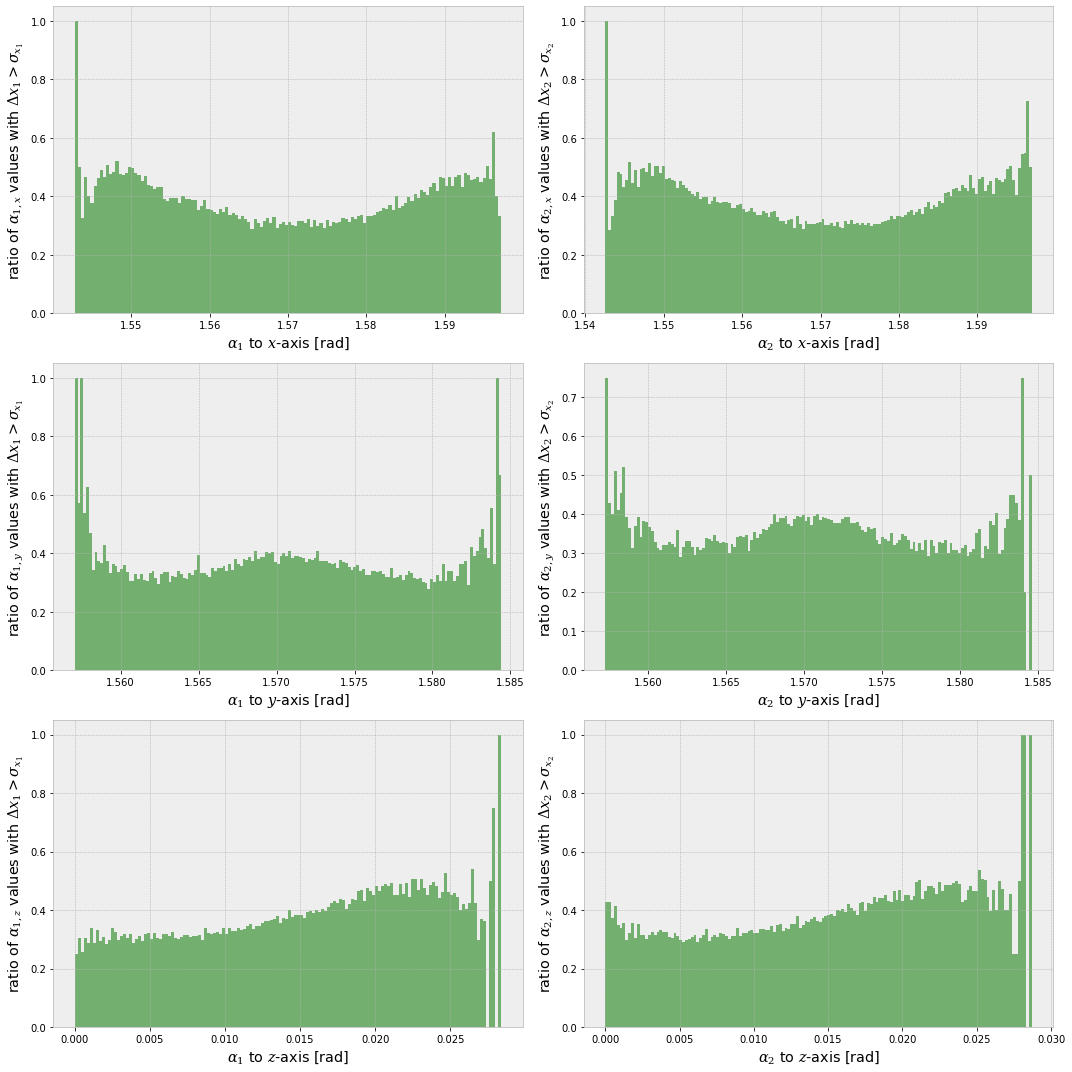

In [96]:
plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(theta_x1_t, bins=b, range=(1.54,1.60))
hist_E1_bad, bins = np.histogram(theta_x1_t[ind_x1_bad], bins=b, range=(1.54,1.60))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, x}$ values with $\Delta x_{1} > \sigma_{x_{1}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(theta_y1_t, bins=b)
hist_x1_bad, bins = np.histogram(theta_y1_t[ind_x1_bad], bins=b)
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, y}$ values with $\Delta x_{1} > \sigma_{x_{1}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(theta_z1_t, bins=b, range=(0,0.03))
hist_y1_bad, bins = np.histogram(theta_z1_t[ind_x1_bad], bins=b, range=(0,0.03))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, z}$ values with $\Delta x_{1} > \sigma_{x_{1}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(theta_x2_t, bins=b)
hist_E2_bad, bins = np.histogram(theta_x2_t[ind_x2_bad], bins=b)
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, x}$ values with $\Delta x_{2} > \sigma_{x_{2}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(theta_y2_t, bins=b)
hist_x2_bad, bins = np.histogram(theta_y2_t[ind_x2_bad], bins=b)
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, y}$ values with $\Delta x_{2} > \sigma_{x_{2}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(theta_z2_t, bins=b)
hist_y2_bad, bins = np.histogram(theta_z2_t[ind_x2_bad], bins=b)
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, z}$ values with $\Delta x_{2} > \sigma_{x_{2}} $")

plt.tight_layout()
plt.show()


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


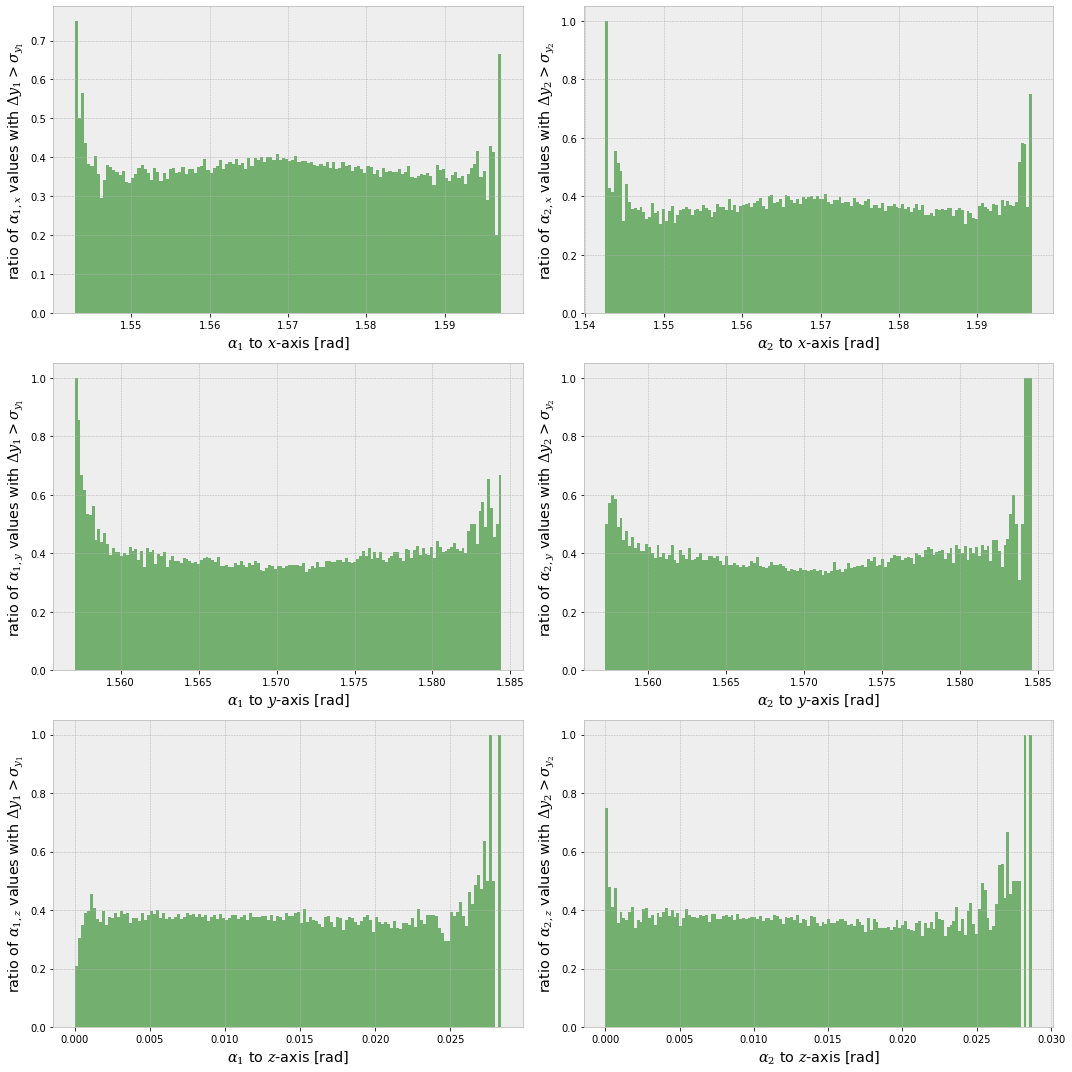

In [97]:

plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(theta_x1_t, bins=b, range=(1.54,1.60))
hist_E1_bad, bins = np.histogram(theta_x1_t[ind_y1_bad], bins=b, range=(1.54,1.60))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, x}$ values with $\Delta y_{1} > \sigma_{y_{1}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(theta_y1_t, bins=b)
hist_x1_bad, bins = np.histogram(theta_y1_t[ind_y1_bad], bins=b)
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, y}$ values with $\Delta y_{1} > \sigma_{y_{1}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(theta_z1_t, bins=b, range=(0,0.03))
hist_y1_bad, bins = np.histogram(theta_z1_t[ind_y1_bad], bins=b, range=(0,0.03))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, z}$ values with $\Delta y_{1} > \sigma_{y_{1}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(theta_x2_t, bins=b)
hist_E2_bad, bins = np.histogram(theta_x2_t[ind_y2_bad], bins=b)
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, x}$ values with $\Delta y_{2} > \sigma_{y_{2}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(theta_y2_t, bins=b)
hist_x2_bad, bins = np.histogram(theta_y2_t[ind_y2_bad], bins=b)
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, y}$ values with $\Delta y_{2} > \sigma_{y_{2}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(theta_z2_t, bins=b)
hist_y2_bad, bins = np.histogram(theta_z2_t[ind_y2_bad], bins=b)
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, z}$ values with $\Delta y_{2} > \sigma_{y_{2}} $")

plt.tight_layout()
plt.show()

